# Objetivo do notebook é aplicar os conceitos apresentados no paper "Mean–variance portfolio optimization using machine learning-based", de Wei Chen et. all.

## [Link](https://sci-hub.se/10.1016/j.asoc.2020.106943 "Artigo")

In [424]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import matplotlib.ticker as mtick
import seaborn as sns
import yfinance as yf

style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore')


from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [425]:
#!pip install yfinance
#yf.pdr_override()
#!pip install stldecompose
#!pip install pandas_datareader

In [426]:

#Lista dos 15 maiores criptoativos em market cap hoje:

ativos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'HEX-USD', 'DOT1-USD', 'UNI3-USD', 'BCH-USD', 'SOL1-USD', 'LINK-USD', 'LTC-USD', 'ICP1-USD']

#O autor avalia os ativos entre novembro/2009 e novembro/2019:
inicio = dt.datetime(2014,1,1)
fim = dt.datetime(2021,8,7)

In [427]:
#Um teste para avaliar o primeiro dos ativos, o Bitcoin:
teste = yf.download("BTC-USD", start=inicio, end=fim)
teste

[*********************100%***********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2021-08-03  39178.402344  39750.031250  37782.050781  38152.980469   
2021-08-04  38213.332031  39952.296875  37589.164062  39747.503906   
2021-08-05  39744.515625  41341.933594  37458.003906  40869.554688   
2021-08-06  40865.867188  43271.660156  39932.179688  42816.500000   
2021-08-07  42832.796875  44689.859375  42618.566406  44555.800781   

               Adj Close       Volume  
Date                                   
2014-09-17    457.334015     21056800  
2014-09-18    424.440002     34483200  
2014-09-19    394.795990     37919700  
2014-09-20    408.903992     36863600  
2014-09-21    398.821014     26580100  
...                  ...          ...  
2021-08-03  38152.980469  26189830450  
2021-08-04  39747.503906  25372562724  
2021-08-05  40869.554688  35185031017  
2021-08-06  42816.500000  38226483046  
2021-08-07  44555.800781  40030862141  

[2513 rows x 6 columns]

In [428]:
# Baixando os dados e organizando num DF:

df_ativos = pd.DataFrame(columns = teste.columns)

for ativo in ativos:
    
    dados = yf.download(ativo, inicio, fim)
    dados['Ativo'] = ativo 
    df_ativos = pd.concat([df_ativos, dados])
    
    
    print(f"Iniciando o download de {ativo}...")
    

[*********************100%***********************]  1 of 1 completed
Iniciando o download de BTC-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de ETH-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de USDT-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de BNB-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de ADA-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de XRP-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de DOGE-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de HEX-USD...
[*********************100%***********************]  1 of 1 completed
Iniciando o download de DOT1-USD...
[*********************100%***********************]  1 of 1 co

In [429]:
df_ativos.shape

(21786, 7)

In [430]:
df_ativos

Open        High         Low       Close   Adj Close  \
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   
...                ...         ...         ...         ...         ...   
2021-08-03   40.202953   40.621689   37.627838   38.450672   38.450672   
2021-08-04   38.558346   40.428940   37.853687   39.313362   39.313362   
2021-08-05   39.324009   42.705814   38.227905   41.993778   41.993778   
2021-08-06   42.102596   52.003258   40.520363   48.237659   48.237659   
2021-08-07   48.248028   65.941826   47.967983   61.842606   61.842606   

                Volume     Ativo  
2014-09-17    21056800   BTC-USD  
2014-09-18    34483200   BTC-USD  
2014-09-19    37919700   BTC-USD  
2014-09-20    36863600   BTC-USD  
2014-09-21    26580100   BTC-USD  
...                ...       ...  
2021-08-03   211961433  ICP1-USD  
2021-08-04   172186967  ICP1-USD  
2021-08-05   211653575  ICP1-USD  
2021-08-06   703665240  ICP1-USD  
2021-08-07  1437084818  ICP1-USD  

[21786 rows x 7 columns]

In [431]:
df_ativos.sort_index(inplace=True) #Organizando o df por datas

In [432]:
df_ativos.isna().sum() #Nenhum dado nulo...

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ativo        0
dtype: int64

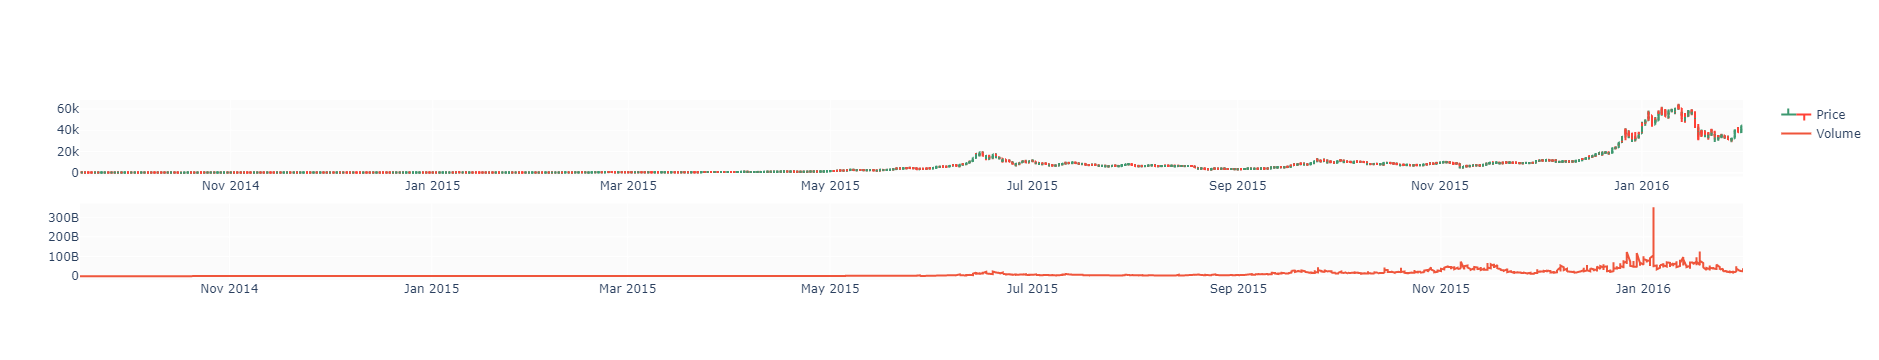

In [433]:
#Exemplo do que estamos lidando: Ativo 1:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df_ativos.index,
                      open=df_ativos[df_ativos['Ativo']=='BTC-USD'].Open,
                      high=df_ativos[df_ativos['Ativo']=='BTC-USD'].High,
                      low=df_ativos[df_ativos['Ativo']=='BTC-USD'].Low,
                      close=df_ativos[df_ativos['Ativo']=='BTC-USD'].Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_ativos.index, y=df_ativos[df_ativos['Ativo']=='BTC-USD'].Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [434]:
df_ativos.groupby(['Ativo']).mean() #Médias de preço de fechamento ['Close']:

Open         High          Low        Close    Adj Close
Ativo                                                                    
ADA-USD      0.278915     0.293999     0.262860     0.279941     0.279941
BCH-USD    536.680961   565.502001   506.992262   536.509332   536.509332
BNB-USD     57.738749    60.621274    54.749031    57.978169    57.978169
BTC-USD   8324.405151  8564.313468  8062.012643  8340.905462  8340.905462
DOGE-USD     0.017501     0.019039     0.016020     0.017605     0.017605
DOT1-USD    18.692737    19.743638    17.539610    18.745647    18.745647
ETH-USD    409.732767   426.153450   391.709831   411.107643   411.107643
HEX-USD      0.022498     0.024336     0.020678     0.022778     0.022778
ICP1-USD    65.638750    71.784184    58.928882    64.415411    64.415411
LINK-USD     6.564180     6.913066     6.182534     6.580892     6.580892
LTC-USD     58.289507    60.726013    55.600899    58.332011    58.332011
SOL1-USD    12.267452    13.145491    11.443901    12.351970    12.351970
UNI3-USD    22.300695    23.531739    20.899827    22.287437    22.287437
USDT-USD     1.000745     1.006836     0.995782     1.000783     1.000783
XRP-USD      0.276120     0.290179     0.261531     0.276456     0.276456

In [435]:
df_ativos.groupby(['Ativo']).count() # -> Nem todos os ativos apresentam cotação para todo o período. Porém há dados que cobrem razoável parte do espectro temporal para cada ativo. Não obstante, alguns ativos mais recentes, como o ICP1, não poderão ser analisados pelo curto prazo de dados.

Open  High   Low  Close  Adj Close  Volume
Ativo                                               
ADA-USD   1403  1403  1403   1403       1403    1403
BCH-USD   1473  1473  1473   1473       1473    1473
BNB-USD   1471  1471  1471   1471       1471    1471
BTC-USD   2513  2513  2513   2513       2513    2513
DOGE-USD  2513  2513  2513   2513       2513    2513
DOT1-USD   330   330   330    330        330     330
ETH-USD   2189  2189  2189   2189       2189    2189
HEX-USD    416   416   416    416        416     416
ICP1-USD    81    81    81     81         81      81
LINK-USD  1414  1414  1414   1414       1414    1414
LTC-USD   2513  2513  2513   2513       2513    2513
SOL1-USD   457   457   457    457        457     457
UNI3-USD   160   160   160    160        160     160
USDT-USD  2340  2340  2340   2340       2340    2340
XRP-USD   2513  2513  2513   2513       2513    2513

In [436]:
#path = r"C:\Users\Alexandre\OneDrive\Documentos\1. PRO\Data Science\Projeto Integrador\Apoio\Abner"
#df_ativos.to_csv(path_or_buf = path+"df_ativos.csv" )

## O paper traz uma série de dados de entrada, que vamos preparar na sequência. São eles:

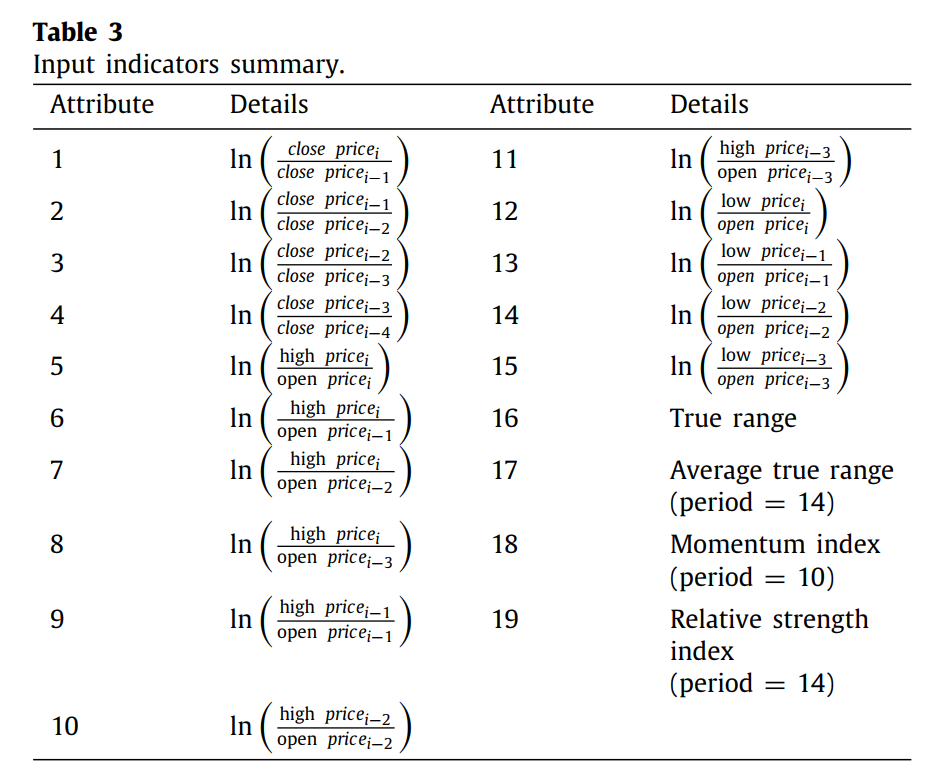

Como se pode observar, são 15 variáveis que envolvem relações temporais entre preços (open, close, high, low), além de 4 outras features muito utilizadas (True Range, Average True Range | 14d, Momentum Index | 10d, Relative Strength Index | 14d).

Na sequência, vamos criar todas essas varíaveis com base nos dados já levantados. Siglas:

* O - Open Price para um dia *"i"* específico
* C - Close Price para um dia *"i"* específico
* H - Highest Price para um dia *"i"* específico
* L - Lowest Price para um dia *"i"* específico



In [437]:
#Criando as features de entrada no DataFrame:

df_ativos['1: ln(C/C-1)'] = pd.Series(dtype=float)
df_ativos['2: ln(C-1/C-2)'] = pd.Series(dtype=float)
df_ativos['3: ln(C-2/C-3)'] = pd.Series(dtype=float)
df_ativos['4: ln(C-3/C-4)'] = pd.Series(dtype=float)
df_ativos['5: ln(H/O)'] = pd.Series(dtype=float)
df_ativos['6: ln(H/O-1)'] = pd.Series(dtype=float)
df_ativos['7: ln(H/O-2)'] = pd.Series(dtype=float)
df_ativos['8: ln(H/O-3)'] = pd.Series(dtype=float)
df_ativos['9: ln(H-1/O-1)'] = pd.Series(dtype=float)
df_ativos['10: ln(H-2/O-2)'] = pd.Series(dtype=float)
df_ativos['11: ln(H-3/O-3)'] = pd.Series(dtype=float)
df_ativos['12: ln(L/O)'] = pd.Series(dtype=float)
df_ativos['13: ln(L-1/O-1)'] = pd.Series(dtype=float)
df_ativos['14: ln(L-2/O-2)'] = pd.Series(dtype=float)
df_ativos['15: ln(L-3/O-3)'] = pd.Series(dtype=float)
df_ativos['16: True Range'] = pd.Series(dtype=float)
df_ativos['17: ATR 14d'] = pd.Series(dtype=float)
df_ativos['18: MI 10d'] = pd.Series(dtype=float)
df_ativos['19: RSI 14d'] = pd.Series(dtype=float)

In [438]:
#Calculando as variáveis com logaritmos naturais "lagged":

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'1: ln(C/C-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] / df_ativos.loc[df_ativos['Ativo'] == ativo,'Close'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'2: ln(C-1/C-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'3: ln(C-2/C-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'4: ln(C-3/C-4)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(4))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'5: ln(H/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'6: ln(H/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'7: ln(H/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'8: ln(H/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'9: ln(H-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'10: ln(H-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'11: ln(H-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'12: ln(L/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'13: ln(L-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'14: ln(L-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'15: ln(L-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))

Variáveis True Range e Average True Range (Explicadas aqui: https://www.investopedia.com/terms/a/atr.asp#:~:text=The%20true%20range%20indicator%20is,days%2C%20of%20the%20true%20ranges.):

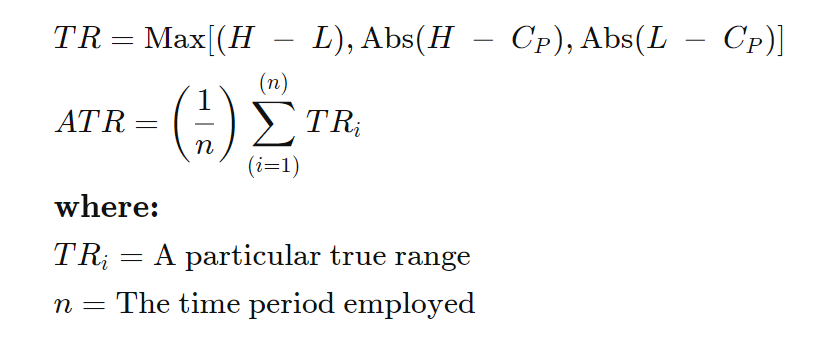



In [439]:
#Calculando as variáveis True Range e Average True Range | 14d:

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'] = np.nanmax([np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low']), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1)), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1))], axis=0)
    
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17: ATR 14d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=14).mean()
    
    



In [440]:
#Calculando a variável MSI | 10d (corresponde à diferença de preços entre o dia atual e o décimo dia anterior. Detalhes: https://help.eaglesmarkets.com/hc/en-us/articles/900002105843-What-are-the-MTM-indicators-Detailed-explanation-of-MTM-index):

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'18: MI 10d'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(10)


In [441]:
#Função para calcular RSI: [Créditos para https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction, levemente modificado para comportar diversos ativos]

def relative_strength_idx(df, ativo, n=14):
    close = df[df['Ativo']==ativo]['Close']
    delta = close.diff()
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100 - (100 / (1 + rs))
    return rsi

for ativo in ativos:

    df_ativos.loc[df_ativos['Ativo'] == ativo,'19: RSI 14d'] = relative_strength_idx(df_ativos,ativo)
    

In [442]:
df_ativos

Open        High         Low       Close   Adj Close  \
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-17    5.085890    5.170770    4.965950    5.058550    5.058550   
2014-09-17    0.005123    0.005803    0.005123    0.005399    0.005399   
2014-09-17    0.000293    0.000299    0.000260    0.000268    0.000268   
2014-09-18    5.065430    5.065430    4.579960    4.685230    4.685230   
...                ...         ...         ...         ...         ...   
2021-08-07    0.204846    0.261990    0.203772    0.260341    0.260341   
2021-08-07   26.168184   28.996151   25.823141   28.185484   28.185484   
2021-08-07    0.134462    0.138729    0.121389    0.127658    0.127658   
2021-08-07   20.421259   21.682161   20.089033   20.967094   20.967094   
2021-08-07   48.248028   65.941826   47.967983   61.842606   61.842606   

                Volume     Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-09-17    21056800   BTC-USD           NaN             NaN   
2014-09-17     3071840   LTC-USD           NaN             NaN   
2014-09-17     1281960   XRP-USD           NaN             NaN   
2014-09-17     1463600  DOGE-USD           NaN             NaN   
2014-09-18     4569260   LTC-USD     -0.076665             NaN   
...                ...       ...           ...             ...   
2021-08-07  6343062404  DOGE-USD      0.240505        0.018311   
2021-08-07   657129565  UNI3-USD      0.074540        0.027938   
2021-08-07    33634523   HEX-USD     -0.052685       -0.074038   
2021-08-07  1715197695  DOT1-USD      0.027386        0.064186   
2021-08-07  1437084818  ICP1-USD      0.248453        0.138619   

            3: ln(C-2/C-3)  ...  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-09-17             NaN  ...              NaN              NaN   
2014-09-17             NaN  ...              NaN              NaN   
2014-09-17             NaN  ...              NaN              NaN   
2014-09-17             NaN  ...              NaN              NaN   
2014-09-18             NaN  ...              NaN              NaN   
...                    ...  ...              ...              ...   
2021-08-07       -0.002564  ...         0.004643         0.034042   
2021-08-07        0.078214  ...         0.080355         0.105874   
2021-08-07       -0.007323  ...         0.063976         0.122887   
2021-08-07       -0.001604  ...         0.015253         0.114065   
2021-08-07        0.065957  ...         0.082500         0.047373   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-09-17    -0.029278              NaN              NaN              NaN   
2014-09-17    -0.023865              NaN              NaN              NaN   
2014-09-17     0.000000              NaN              NaN              NaN   
2014-09-17    -0.119491              NaN              NaN              NaN   
2014-09-18    -0.100749        -0.023865              NaN              NaN   
...                 ...              ...              ...              ...   
2021-08-07    -0.005257        -0.011728        -0.034779        -0.009530   
2021-08-07    -0.013273        -0.035428        -0.061063        -0.024530   
2021-08-07    -0.102281        -0.085861        -0.007015        -0.017599   
2021-08-07    -0.016402        -0.030597        -0.067394        -0.016669   
2021-08-07    -0.005821        -0.038305        -0.028269        -0.018444   

            16: True Range  17: ATR 14d  18: MI 10d  19: RSI 14d  
2014-09-17       15.752014          NaN         NaN          NaN  
2014-09-17        0.204820          NaN         NaN          NaN  
2014-09-17        0.000680          NaN         NaN          NaN  
2014-09-17        0.000039          NaN         NaN          NaN  
2014-09-18        0.485470          NaN         NaN          NaN  
...                    ...          ...         ...          ...  
2021-08-07        0.058218     0.015893    0.054949    84.131634  
2021-08-07        3.173010     1.8

In [443]:
df_ativos_sna = df_ativos.dropna() #Muitas métricas precisam de mais dias de medição, de forma que os primeiros são nulos. Ao final, partimos do dia 20/11/2009 para a análise. Lembrando que aqui dropamos as ocorrências intrinsecamente ligadas a cada ativo, de forma que um ativo não atrapalha o outro.
df_ativos_sna

Open        High         Low       Close   Adj Close  \
2014-10-01    4.470960    4.503740    4.384860    4.428560    4.428560   
2014-10-01    0.004645    0.004772    0.004644    0.004752    0.004752   
2014-10-01    0.000400    0.000406    0.000371    0.000371    0.000371   
2014-10-01  387.427002  391.378998  380.779999  383.614990  383.614990   
2014-10-02    0.004755    0.004876    0.004753    0.004874    0.004874   
...                ...         ...         ...         ...         ...   
2021-08-07    0.204846    0.261990    0.203772    0.260341    0.260341   
2021-08-07   26.168184   28.996151   25.823141   28.185484   28.185484   
2021-08-07    0.134462    0.138729    0.121389    0.127658    0.127658   
2021-08-07   20.421259   21.682161   20.089033   20.967094   20.967094   
2021-08-07   48.248028   65.941826   47.967983   61.842606   61.842606   

                Volume     Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-10-01     1172180   LTC-USD     -0.010372        0.052283   
2014-10-01       64998   XRP-USD      0.022989       -0.013050   
2014-10-01     1031360  DOGE-USD     -0.072759        0.007547   
2014-10-01    26229400   BTC-USD     -0.008641        0.030109   
2014-10-02      209158   XRP-USD      0.025349        0.022989   
...                ...       ...           ...             ...   
2021-08-07  6343062404  DOGE-USD      0.240505        0.018311   
2021-08-07   657129565  UNI3-USD      0.074540        0.027938   
2021-08-07    33634523   HEX-USD     -0.052685       -0.074038   
2021-08-07  1715197695  DOT1-USD      0.027386        0.064186   
2021-08-07  1437084818  ICP1-USD      0.248453        0.138619   

            3: ln(C-2/C-3)  ...  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01        0.003198  ...         0.021621         0.007428   
2014-10-01       -0.115679  ...         0.030410         0.127323   
2014-10-01        0.010152  ...         0.017611         0.096277   
2014-10-01       -0.004555  ...         0.021737         0.003863   
2014-10-02       -0.013050  ...         0.000425         0.030410   
...                    ...  ...              ...              ...   
2021-08-07       -0.002564  ...         0.004643         0.034042   
2021-08-07        0.078214  ...         0.080355         0.105874   
2021-08-07       -0.007323  ...         0.063976         0.122887   
2021-08-07       -0.001604  ...         0.015253         0.114065   
2021-08-07        0.065957  ...         0.082500         0.047373   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.019445        -0.006195        -0.009372        -0.051438   
2014-10-01    -0.000215        -0.014990        -0.125150        -0.011971   
2014-10-01    -0.075262        -0.028099        -0.041457         0.000000   
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.000421        -0.000215        -0.014990        -0.125150   
...                 ...              ...              ...              ...   
2021-08-07    -0.005257        -0.011728        -0.034779        -0.009530   
2021-08-07    -0.013273        -0.035428        -0.061063        -0.024530   
2021-08-07    -0.102281        -0.085861        -0.007015        -0.017599   
2021-08-07    -0.016402        -0.030597        -0.067394        -0.016669   
2021-08-07    -0.005821        -0.038305        -0.028269        -0.018444   

            16: True Range  17: ATR 14d  18: MI 10d  19: RSI 14d  
2014-10-01        0.118880     0.276422    0.182640    35.151758  
2014-10-01        0.000128     0.000272    0.000182    37.495167  
2014-10-01        0.000035     0.000042    0.000083    64.265928  
2014-10-01       10.598999    22.595568  -15.206024    31.461697  
2014-10-02        0.000124     0.000250    0.000217    44.662570  
...                    ...          ...         ...          ...  
2021-08-07        0.058218     0.015893    0.054949    84.131634  
2021-08-07        3.173010     1.8

In [444]:
#Dúvida que não quer calar: Usar tudo pra fazer um modelo só (passando OneHotEncoder na feature 'Ativo' e deixando os preços dos ativos se autoinfluenciarem) ou fazer um modelo pra cada ativo?!

In [445]:
#Um modelo pra cada ativo parece fazer mais sentido... 
#Acho que o melhor caminho seria por um dicionário de DFs, uma entrada pra cada ativo.
#Separando os dataframes para cada Ativo em um dicionário, para  e gerar as features de interesse:

dict_ativos = {}

for ativo in ativos:
    dict_ativos[ativo] = df_ativos_sna[df_ativos_sna['Ativo']==ativo]
    

In [446]:
#Fazendo um split do dataset em 80% treino, 20% teste e armazenando cada um em dicionário específico, já retirando as variáveis não desejadas: 

test_size  = 0.20

dict_train = {}
dict_test = {}

dict_X_train = {}
dict_X_test = {}

dict_y_train = {}
dict_y_test = {}


lista_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume',	'Ativo']

for ativo, df in dict_ativos.items():

    test_split_idx  = int(df.shape[0] * (1-test_size))

#Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
#Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.
  
    
    df['Close'] = df.loc[:,'Close'].shift(-1) #Gera um NA, então vamos ter que dropar novamente...
    df.dropna(inplace=True)
    
    df_train  = df.iloc[:test_split_idx].copy()
    df_test   = df.iloc[test_split_idx+1:].copy()
    
    X_train = df_train.drop(columns = lista_drop).drop(columns='Close')
    X_test = df_test.drop(columns = lista_drop).drop(columns='Close')
    
    y_train = df_train['Close']
    y_test = df_test['Close']

    dict_train[ativo] = df_train.drop(columns = lista_drop)
    dict_test[ativo] = df_test.drop(columns = lista_drop)
    
    dict_X_train[ativo] = X_train
    dict_X_test[ativo] = X_test
    
    dict_y_train[ativo] = y_train
    dict_y_test[ativo] = y_test

## Análise exploratória do BTC

In [447]:
df_BTC = list(dict_ativos.values())[0]
df_BTC

Open          High           Low         Close  \
2014-10-01    387.427002    391.378998    380.779999    375.071991   
2014-10-02    383.988007    385.497009    372.946014    359.511993   
2014-10-03    375.181000    377.695007    357.859009    328.865997   
2014-10-04    359.891998    364.487000    325.885986    320.510010   
2014-10-05    328.915985    341.800995    289.295990    330.079010   
...                  ...           ...           ...           ...   
2021-08-02  39907.261719  40419.179688  38746.347656  38152.980469   
2021-08-03  39178.402344  39750.031250  37782.050781  39747.503906   
2021-08-04  38213.332031  39952.296875  37589.164062  40869.554688   
2021-08-05  39744.515625  41341.933594  37458.003906  42816.500000   
2021-08-06  40865.867188  43271.660156  39932.179688  44555.800781   

               Adj Close       Volume    Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-10-01    383.614990     26229400  BTC-USD     -0.008641        0.030109   
2014-10-02    375.071991     21777700  BTC-USD     -0.022521       -0.008641   
2014-10-03    359.511993     30901200  BTC-USD     -0.042370       -0.022521   
2014-10-04    328.865997     47236500  BTC-USD     -0.089097       -0.042370   
2014-10-05    320.510010     83308096  BTC-USD     -0.025737       -0.089097   
...                  ...          ...      ...           ...             ...   
2021-08-02  39201.945312  25595265436  BTC-USD     -0.019525       -0.040478   
2021-08-03  38152.980469  26189830450  BTC-USD     -0.027122       -0.019525   
2021-08-04  39747.503906  25372562724  BTC-USD      0.040943       -0.027122   
2021-08-05  40869.554688  35185031017  BTC-USD      0.027838        0.040943   
2021-08-06  42816.500000  38226483046  BTC-USD      0.046538        0.027838   

            3: ln(C-2/C-3)  ...  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01       -0.004555  ...         0.021737         0.003863   
2014-10-02        0.030109  ...         0.038826         0.021737   
2014-10-03       -0.008641  ...         0.010149         0.038826   
2014-10-04       -0.022521  ...         0.003922         0.010149   
2014-10-05       -0.042370  ...         0.006678         0.003922   
...                    ...  ...              ...              ...   
2021-08-02       -0.014533  ...         0.000833         0.053696   
2021-08-03       -0.040478  ...         0.025735         0.000833   
2021-08-04       -0.019525  ...         0.012746         0.025735   
2021-08-05       -0.027122  ...         0.014485         0.012746   
2021-08-06        0.040943  ...         0.044502         0.014485   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.029178        -0.017306        -0.007058        -0.012515   
2014-10-03    -0.047269        -0.029178        -0.017306        -0.007058   
2014-10-04    -0.099256        -0.047269        -0.029178        -0.017306   
2014-10-05    -0.128352        -0.099256        -0.047269        -0.029178   
...                 ...              ...              ...              ...   
2021-08-02    -0.029522        -0.047413        -0.026061        -0.041578   
2021-08-03    -0.036291        -0.029522        -0.047413        -0.026061   
2021-08-04    -0.016469        -0.036291        -0.029522        -0.047413   
2021-08-05    -0.059251        -0.016469        -0.036291        -0.029522   
2021-08-06    -0.023113        -0.059251        -0.016469        -0.036291   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2014-10-01       10.598999    22.595568   -15.206024    31.461697  
2014-10-02       12.550995    20.332781   -27.080017    35.852649  
2014-10-03       19.835999    18.656568   -76.278992    39.000831  
2014-10-04       38.601013    19.027141   -94.338989    27.381697  
2014-10-05       52.505005    21.402856   -91.063995    27.651597  
...                    ...          ...     

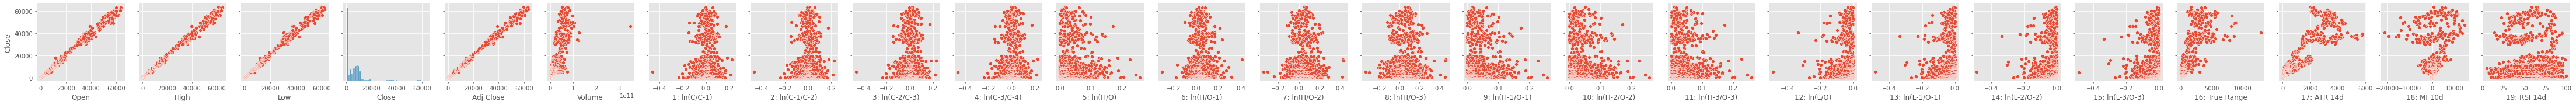

In [448]:
sns.pairplot(data = df_BTC, y_vars="Close")

In [449]:
#Preços de bitcoin na época de treino:
list(dict_train.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2014-10-01   375.071991     -0.008641        0.030109       -0.004555   
2014-10-02   359.511993     -0.022521       -0.008641        0.030109   
2014-10-03   328.865997     -0.042370       -0.022521       -0.008641   
2014-10-04   320.510010     -0.089097       -0.042370       -0.022521   
2014-10-05   330.079010     -0.025737       -0.089097       -0.042370   
...                 ...           ...             ...             ...   
2020-03-17  5238.438477      0.041246       -0.072645        0.036246   
2020-03-18  6191.192871      0.002448        0.041246       -0.072645   
2020-03-19  6198.778320      0.167104        0.002448        0.041246   
2020-03-20  6185.066406      0.001224        0.167104        0.002448   
2020-03-21  5830.254883     -0.002214        0.001224        0.167104   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2014-10-01       -0.057539    0.010149      0.039853      0.037622   
2014-10-02       -0.004555    0.003922     -0.004994      0.024710   
2014-10-03        0.030109    0.006678     -0.016524     -0.025440   
2014-10-04       -0.008641    0.012687     -0.028918     -0.052120   
2014-10-05       -0.022521    0.038426     -0.051575     -0.093180   
...                    ...         ...           ...           ...   
2020-03-17       -0.067536    0.071126     -0.002581      0.032215   
2020-03-18        0.036246    0.019836      0.063742     -0.009965   
2020-03-19       -0.072645    0.187904      0.191399      0.235305   
2020-03-20        0.041246    0.100208      0.266056      0.269551   
2020-03-21        0.002448    0.027275      0.029674      0.195521   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01     -0.020465        0.038826         0.021737         0.003863   
2014-10-02      0.022479        0.010149         0.038826         0.021737   
2014-10-03      0.004264        0.003922         0.010149         0.038826   
2014-10-04     -0.061037        0.006678         0.003922         0.010149   
2014-10-05     -0.116383        0.012687         0.006678         0.003922   
...                  ...             ...              ...              ...   
2020-03-17     -0.036868        0.000000         0.115292         0.009314   
2020-03-18      0.024831        0.071126         0.000000         0.115292   
2020-03-19      0.161599        0.019836         0.071126         0.000000   
2020-03-20      0.313457        0.187904         0.019836         0.071126   
2020-03-21      0.199017        0.100208         0.187904         0.019836   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.029178        -0.017306        -0.007058        -0.012515   
2014-10-03    -0.047269        -0.029178        -0.017306        -0.007058   
2014-10-04    -0.099256        -0.047269        -0.029178        -0.017306   
2014-10-05    -0.128352        -0.099256        -0.047269        -0.029178   
...                 ...              ...              ...              ...   
2020-03-17    -0.004140        -0.162975        -0.006130        -0.083803   
2020-03-18    -0.030649        -0.004140        -0.162975        -0.006130   
2020-03-19    -0.001612        -0.030649        -0.004140        -0.162975   
2020-03-20    -0.054066        -0.001612        -0.030649        -0.004140   
2020-03-21    -0.045100        -0.054066        -0.001612        -0.030649   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2014-10-01       10.598999    22.595568   -15.206024    31.461697  
2014-10-02       12.550995    20.332781   -27.080017    35.852649  
2014-10-03       19.835999    18.656568   -76.278992    39.000831  
2014-10-04       38.601013    19.027141   -94.338989    27.381697  
2014-10-05       52.505005    21.402856   -91.063995    27.651597  
...               

In [450]:
#Teste:
list(dict_test.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2020-03-23   6734.803711      0.095783       -0.059077       -0.002214   
2020-03-24   6681.062988      0.048445        0.095783       -0.059077   
2020-03-25   6716.440430     -0.008012        0.048445        0.095783   
2020-03-26   6469.798340      0.005281       -0.008012        0.048445   
2020-03-27   6242.193848     -0.037413        0.005281       -0.008012   
...                  ...           ...             ...             ...   
2021-08-02  38152.980469     -0.019525       -0.040478       -0.014533   
2021-08-03  39747.503906     -0.027122       -0.019525       -0.040478   
2021-08-04  40869.554688      0.040943       -0.027122       -0.019525   
2021-08-05  42816.500000      0.027838        0.040943       -0.027122   
2021-08-06  44555.800781      0.046538        0.027838        0.040943   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2020-03-23        0.001224    0.099887      0.040922      0.037539   
2020-03-24       -0.002214    0.053300      0.152054      0.093090   
2020-03-25       -0.059077    0.022566      0.068428      0.167183   
2020-03-26        0.095783    0.008992     -0.000483      0.045380   
2020-03-27        0.048445    0.011019      0.017621      0.008146   
...                    ...         ...           ...           ...   
2021-08-02        0.054172    0.012746     -0.025445     -0.043028   
2021-08-03       -0.014533    0.014485     -0.003948     -0.042139   
2021-08-04       -0.040478    0.044502      0.019561      0.001128   
2021-08-05       -0.019525    0.039405      0.078693      0.053752   
2021-08-06       -0.027122    0.057203      0.085026      0.124313   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2020-03-23      0.039937        0.027764         0.027275         0.100208   
2020-03-24      0.089706        0.099887         0.027764         0.027275   
2020-03-25      0.108218        0.053300         0.099887         0.027764   
2020-03-26      0.144134        0.022566         0.053300         0.099887   
2020-03-27      0.054009        0.008992         0.022566         0.053300   
...                  ...             ...              ...              ...   
2021-08-02      0.009738        0.025735         0.000833         0.053696   
2021-08-03     -0.059722        0.012746         0.025735         0.000833   
2021-08-04     -0.037063        0.014485         0.012746         0.025735   
2021-08-05      0.035319        0.044502         0.014485         0.012746   
2021-08-06      0.099372        0.039405         0.044502         0.014485   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2020-03-23    -0.007984        -0.060279        -0.045100        -0.054066   
2020-03-24    -0.003981        -0.007984        -0.060279        -0.045100   
2020-03-25    -0.030402        -0.003981        -0.007984        -0.060279   
2020-03-26    -0.012695        -0.030402        -0.003981        -0.007984   
2020-03-27    -0.038331        -0.012695        -0.030402        -0.003981   
...                 ...              ...              ...              ...   
2021-08-02    -0.029522        -0.047413        -0.026061        -0.041578   
2021-08-03    -0.036291        -0.029522        -0.047413        -0.026061   
2021-08-04    -0.016469        -0.036291        -0.029522        -0.047413   
2021-08-05    -0.059251        -0.016469        -0.036291        -0.029522   
2021-08-06    -0.023113        -0.059251        -0.016469        -0.036291   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2020-03-23      658.930176   841.283308   852.607910    38.617370  
2020-03-24      377.956543   845.267194  1534.437500    41.517708  
2020-03-25      355.584961   848.665981  1288.748047    41.183699  
2020-03-26      144.500977   639.790179  1701.960449    71.432026  
2020-03-27      327.134766   539.504534  1244.168945    62.158202  
...    

# Agora vamos fazer diferente... vamos separar os datasets de treino e de teste em alguns blocos, espalhados no tempo, já que os níveis de preço são muito diferentes ao longo do tempo:

In [451]:
df.shape[0]

66

In [452]:
test_size  = 0.20
train_size = 1 - test_size
n_blocos = 3

test_split_idx = [0]
for bloco in range(0, 2*n_blocos-1):
    
        if bloco % 2 == 0:
            print(bloco)
            test_split_idx.append(test_split_idx[bloco] + int(df.shape[0] * (train_size)/n_blocos))
        
        elif bloco % 2 != 0:
            print(bloco)
            test_split_idx.append(test_split_idx[bloco] + int(df.shape[0] * (test_size)/n_blocos))

test_split_idx

0
1
2
3
4


[0, 17, 21, 38, 42, 59]

In [453]:
df_test.append(df.iloc[split_idx[bloco-1]:split_idx[bloco]])

Open       High        Low      Close  Adj Close     Volume  \
2021-07-26  42.637703  48.107082  40.520557  40.935661  40.647243  534657011   
2021-07-27  40.631435  41.660706  37.619678  40.673225  40.935661  411753144   
2021-07-28  41.072357  43.852062  39.485840  41.209164  40.673225  328845351   
2021-07-29  40.762123  41.810162  39.253513  42.153149  41.209164  202258965   
2021-07-30  41.262417  42.697388  38.425259  41.718895  42.153149  237668877   
2021-07-31  42.177826  43.852367  40.445457  40.914368  41.718895  238887679   
2021-08-01  41.841103  44.386318  40.626381  40.203678  40.914368  254763679   
2021-08-02  40.906059  41.506218  39.900795  38.450672  40.203678  190864848   
2021-08-03  40.202953  40.621689  37.627838  39.313362  38.450672  211961433   
2021-08-04  38.558346  40.428940  37.853687  41.993778  39.313362  172186967   
2021-08-05  39.324009  42.705814  38.227905  48.237659  41.993778  211653575   
2021-08-06  42.102596  52.003258  40.520363  61.842606  48.237659  703665240   
2021-06-24  37.781269  38.873222  33.257675  31.197479  34.641438  209852877   
2021-06-25  34.586136  36.636868  30.701866  30.297642  31.197479  199988023   

               Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  ...  \
2021-07-26  ICP1-USD     -0.046637       -0.020378        0.226613  ...   
2021-07-27  ICP1-USD      0.007071       -0.046637       -0.020378  ...   
2021-07-28  ICP1-USD     -0.006432        0.007071       -0.046637  ...   
2021-07-29  ICP1-USD      0.013091       -0.006432        0.007071  ...   
2021-07-30  ICP1-USD      0.022649        0.013091       -0.006432  ...   
2021-07-31  ICP1-USD     -0.010355        0.022649        0.013091  ...   
2021-08-01  ICP1-USD     -0.019473       -0.010355        0.022649  ...   
2021-08-02  ICP1-USD     -0.017523       -0.019473       -0.010355  ...   
2021-08-03  ICP1-USD     -0.044582       -0.017523       -0.019473  ...   
2021-08-04  ICP1-USD      0.022188       -0.044582       -0.017523  ...   
2021-08-05  ICP1-USD      0.065957        0.022188       -0.044582  ...   
2021-08-06  ICP1-USD      0.138619        0.065957        0.022188  ...   
2021-06-24  ICP1-USD     -0.072733        0.079328       -0.066111  ...   
2021-06-25  ICP1-USD     -0.104713       -0.072733        0.079328  ...   

            10: ln(H-2/O-2)  11: ln(H-3/O-3)  12: ln(L/O)  13: ln(L-1/O-1)  \
2021-07-26         0.276971         0.036857    -0.050929        -0.072398   
2021-07-27         0.051479         0.276971    -0.077015        -0.050929   
2021-07-28         0.120691         0.051479    -0.039393        -0.077015   
2021-07-29         0.025016         0.120691    -0.037712        -0.039393   
2021-07-30         0.065486         0.025016    -0.071237        -0.037712   
2021-07-31         0.025386         0.065486    -0.041940        -0.071237   
2021-08-01         0.034186         0.025386    -0.029462        -0.041940   
2021-08-02         0.038934         0.034186    -0.024882        -0.029462   
2021-08-03         0.059052         0.038934    -0.066196        -0.024882   
2021-08-04         0.014565         0.059052    -0.018444        -0.066196   
2021-08-05         0.010362         0.014565    -0.028269        -0.018444   
2021-08-06         0.047373         0.010362    -0.038305        -0.028269   
2021-06-24         0.088650         0.007339    -0.127528        -0.041982   
2021-06-25         0.170451         0.088650    -0.119129        -0.127528   

            14: ln(L-2/O-2)  15: ln(L-3/O-3)  16: True Range  17: ATR 14d  \
2021-07-26        -0.020211        -0.060729        7.586525     4.729516   
2021-07-27        -0.072398        -0.020211        4.041027     4.692967   
2021-07-28        -0.050929        -0.072398        4.366222     4.696792   
2021-07-29        -0.077015        -0.050929        2.556648     4.669829   
2021-07-30        -0.039393        -0.077015        4.272129     4.706651   
2021-07-31        -0.037712        -0.039393        3.406

In [454]:
test_size  = 0.20
train_size = 1- test_size
n_blocos = 5

dict_train = {}
dict_test = {}

dict_X_train = {}
dict_X_test = {}

dict_y_train = {}
dict_y_test = {}


lista_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume',	'Ativo']

for ativo, df in dict_ativos.items():

    #Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
    #Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.
    
#NÃO ESQUECER DE TIRAR ESSE COMENTÁRIO DEPOIS!    df['Close'] = df.loc[:,'Close'].shift(-1) #Gera um NA, então vamos ter que dropar novamente...      
    df.dropna(inplace=True)
    
    
    
    #Agora vamos calcular os index de cada inicio e fim de blocos de treino e teste e alocar os dados aos dfs pertinentes (treino ou teste):
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    
    split_idx = [0]
    print(f"\nAtivo = {ativo}")
    
    for bloco in range(0, 2*n_blocos):
        
        print(f"bloco: {bloco}")
        
        if bloco % 2 == 0:
            print("Bloco é par")
            
            split_idx.append(split_idx[bloco] + int(df.shape[0] * (train_size)/n_blocos))
            
            print(f"Índice calculado: {split_idx[bloco] + int(df.shape[0] * (train_size)/n_blocos)}")
            
            df_train = df_train.append(df.iloc[split_idx[-2]:split_idx[-1]])
            
            print(f"adicionamos o slice entre {split_idx[-2]} e {split_idx[-1]} ao df_train")
           # if bloco != 0:
                
                #print("Bloco não é igual a zero")
                
               # if bloco != 2*n_blocos :
                    
                    #print(f"Bloco não é igual ao último bloco: {2*n_blocos}")
                    
                   # df_test = df_test.append(df.iloc[split_idx[bloco-1]:split_idx[bloco]])
                    
                   # print(f"adicionamos o slice entre {split_idx[bloco-1]} e {split_idx[bloco]} ao df_test")
                
                #elif bloco == 2*n_blocos :
                    
                   # print(f"Bloco é igual ao último bloco: {2*n_blocos}")
                    
                    #df_test = df_test.append(df.iloc[split_idx[bloco]:])
                    
                   # print(f"adicionamos o slice entre {split_idx[bloco]} e o final do dataset ao df_test")
        
        elif bloco % 2 != 0 :
            
            print("Bloco é ímpar")
            
            if bloco != (range(0, 2*n_blocos)[-1]):
            
                split_idx.append(split_idx[bloco] + int(df.shape[0] * (test_size)/n_blocos))
                
                print(f"Índice calculado: {split_idx[bloco] + int(df.shape[0] * (test_size)/n_blocos)}")
                
                df_test = df_test.append(df.iloc[split_idx[-2]+1:split_idx[-1]-1])

                print(f"adicionamos o slice entre {split_idx[-2]+1} e {split_idx[-1]-1} ao df_test")
            
            elif bloco == (range(0, 2*n_blocos)[-1]):
            
                 df_test = df_test.append(df.iloc[split_idx[-1]+1:])

                 print(f"Bloco é igual ao último bloco, {2*n_blocos}, e adicionamos o slice entre {split_idx[-1]+1} e o final do dataset ao df_test")
            
            
            
            #___________________DAQUI PRA CIMA ESTÁ OK, VAMOS INCLUIR OS ÍNDICES NOS CÁLCULOS DOS DFs TREINO E TESTE_________________#
    
        #df_train  = df.iloc[split_idx[bloco]].copy().append(df.iloc[split_idx[bloco]+1:split_idx].copy()) 
        #df_test   = df.iloc[split_idx[bloco]+1:split_idx[bloco+1]].copy().append(df.iloc[split_idx+1:].copy())
    
    X_train = df_train.drop(columns = lista_drop).drop(columns='Close')
    X_test = df_test.drop(columns = lista_drop).drop(columns='Close')
    
    y_train = df_train['Close']
    y_test = df_test['Close']

    dict_train[ativo] = df_train.drop(columns = lista_drop)
    dict_test[ativo] = df_test.drop(columns = lista_drop)
    
    dict_X_train[ativo] = X_train
    dict_X_test[ativo] = X_test
    
    dict_y_train[ativo] = y_train
    dict_y_test[ativo] = y_test


Ativo = BTC-USD
bloco: 0
Bloco é par
Índice calculado: 399
adicionamos o slice entre 0 e 399 ao df_train
bloco: 1
Bloco é ímpar
Índice calculado: 498
adicionamos o slice entre 400 e 497 ao df_test
bloco: 2
Bloco é par
Índice calculado: 897
adicionamos o slice entre 498 e 897 ao df_train
bloco: 3
Bloco é ímpar
Índice calculado: 996
adicionamos o slice entre 898 e 995 ao df_test
bloco: 4
Bloco é par
Índice calculado: 1395
adicionamos o slice entre 996 e 1395 ao df_train
bloco: 5
Bloco é ímpar
Índice calculado: 1494
adicionamos o slice entre 1396 e 1493 ao df_test
bloco: 6
Bloco é par
Índice calculado: 1893
adicionamos o slice entre 1494 e 1893 ao df_train
bloco: 7
Bloco é ímpar
Índice calculado: 1992
adicionamos o slice entre 1894 e 1991 ao df_test
bloco: 8
Bloco é par
Índice calculado: 2391
adicionamos o slice entre 1992 e 2391 ao df_train
bloco: 9
Bloco é ímpar
Bloco é igual ao último bloco, 10, e adicionamos o slice entre 2392 e o final do dataset ao df_test

Ativo = ETH-USD
bloco: 0

In [455]:
list(dict_ativos.values())[0]

Open          High           Low         Close  \
2014-10-01    387.427002    391.378998    380.779999    375.071991   
2014-10-02    383.988007    385.497009    372.946014    359.511993   
2014-10-03    375.181000    377.695007    357.859009    328.865997   
2014-10-04    359.891998    364.487000    325.885986    320.510010   
2014-10-05    328.915985    341.800995    289.295990    330.079010   
...                  ...           ...           ...           ...   
2021-08-02  39907.261719  40419.179688  38746.347656  38152.980469   
2021-08-03  39178.402344  39750.031250  37782.050781  39747.503906   
2021-08-04  38213.332031  39952.296875  37589.164062  40869.554688   
2021-08-05  39744.515625  41341.933594  37458.003906  42816.500000   
2021-08-06  40865.867188  43271.660156  39932.179688  44555.800781   

               Adj Close       Volume    Ativo  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-10-01    383.614990     26229400  BTC-USD     -0.008641        0.030109   
2014-10-02    375.071991     21777700  BTC-USD     -0.022521       -0.008641   
2014-10-03    359.511993     30901200  BTC-USD     -0.042370       -0.022521   
2014-10-04    328.865997     47236500  BTC-USD     -0.089097       -0.042370   
2014-10-05    320.510010     83308096  BTC-USD     -0.025737       -0.089097   
...                  ...          ...      ...           ...             ...   
2021-08-02  39201.945312  25595265436  BTC-USD     -0.019525       -0.040478   
2021-08-03  38152.980469  26189830450  BTC-USD     -0.027122       -0.019525   
2021-08-04  39747.503906  25372562724  BTC-USD      0.040943       -0.027122   
2021-08-05  40869.554688  35185031017  BTC-USD      0.027838        0.040943   
2021-08-06  42816.500000  38226483046  BTC-USD      0.046538        0.027838   

            3: ln(C-2/C-3)  ...  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01       -0.004555  ...         0.021737         0.003863   
2014-10-02        0.030109  ...         0.038826         0.021737   
2014-10-03       -0.008641  ...         0.010149         0.038826   
2014-10-04       -0.022521  ...         0.003922         0.010149   
2014-10-05       -0.042370  ...         0.006678         0.003922   
...                    ...  ...              ...              ...   
2021-08-02       -0.014533  ...         0.000833         0.053696   
2021-08-03       -0.040478  ...         0.025735         0.000833   
2021-08-04       -0.019525  ...         0.012746         0.025735   
2021-08-05       -0.027122  ...         0.014485         0.012746   
2021-08-06        0.040943  ...         0.044502         0.014485   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.029178        -0.017306        -0.007058        -0.012515   
2014-10-03    -0.047269        -0.029178        -0.017306        -0.007058   
2014-10-04    -0.099256        -0.047269        -0.029178        -0.017306   
2014-10-05    -0.128352        -0.099256        -0.047269        -0.029178   
...                 ...              ...              ...              ...   
2021-08-02    -0.029522        -0.047413        -0.026061        -0.041578   
2021-08-03    -0.036291        -0.029522        -0.047413        -0.026061   
2021-08-04    -0.016469        -0.036291        -0.029522        -0.047413   
2021-08-05    -0.059251        -0.016469        -0.036291        -0.029522   
2021-08-06    -0.023113        -0.059251        -0.016469        -0.036291   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2014-10-01       10.598999    22.595568   -15.206024    31.461697  
2014-10-02       12.550995    20.332781   -27.080017    35.852649  
2014-10-03       19.835999    18.656568   -76.278992    39.000831  
2014-10-04       38.601013    19.027141   -94.338989    27.381697  
2014-10-05       52.505005    21.402856   -91.063995    27.651597  
...                    ...          ...     

In [456]:
#Acessando, por exemplo, o df_train do primeiro ativo, o BTC:
list(dict_train.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2014-10-01    375.071991     -0.008641        0.030109       -0.004555   
2014-10-02    359.511993     -0.022521       -0.008641        0.030109   
2014-10-03    328.865997     -0.042370       -0.022521       -0.008641   
2014-10-04    320.510010     -0.089097       -0.042370       -0.022521   
2014-10-05    330.079010     -0.025737       -0.089097       -0.042370   
...                  ...           ...             ...             ...   
2021-04-17  56216.183594     -0.014543       -0.027887        0.003232   
2021-04-18  55724.265625     -0.076472       -0.014543       -0.027887   
2021-04-19  56473.031250     -0.008789       -0.076472       -0.014543   
2021-04-20  53906.089844      0.013348       -0.008789       -0.076472   
2021-04-21  51762.273438     -0.046520        0.013348       -0.008789   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2014-10-01       -0.057539    0.010149      0.039853      0.037622   
2014-10-02       -0.004555    0.003922     -0.004994      0.024710   
2014-10-03        0.030109    0.006678     -0.016524     -0.025440   
2014-10-04       -0.008641    0.012687     -0.028918     -0.052120   
2014-10-05       -0.022521    0.038426     -0.051575     -0.093180   
...                    ...         ...           ...           ...   
2021-04-17       -0.006220    0.016797     -0.010909     -0.008007   
2021-04-18        0.003232    0.005841     -0.007708     -0.035414   
2021-04-19       -0.027887    0.023367     -0.053841     -0.067390   
2021-04-20       -0.014543    0.024488      0.015374     -0.061834   
2021-04-21       -0.076472    0.005067      0.019143      0.010029   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2014-10-01     -0.020465        0.038826         0.021737         0.003863   
2014-10-02      0.022479        0.010149         0.038826         0.021737   
2014-10-03      0.004264        0.003922         0.010149         0.038826   
2014-10-04     -0.061037        0.006678         0.003922         0.010149   
2014-10-05     -0.116383        0.012687         0.006678         0.003922   
...                  ...             ...              ...              ...   
2021-04-17     -0.015093        0.005301         0.011765         0.020865   
2021-04-18     -0.032512        0.016797         0.005301         0.011765   
2021-04-19     -0.095096        0.005841         0.016797         0.005301   
2021-04-20     -0.075383        0.023367         0.005841         0.016797   
2021-04-21     -0.067179        0.024488         0.023367         0.005841   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2014-10-01    -0.017306        -0.007058        -0.012515        -0.064998   
2014-10-02    -0.029178        -0.017306        -0.007058        -0.012515   
2014-10-03    -0.047269        -0.029178        -0.017306        -0.007058   
2014-10-04    -0.099256        -0.047269        -0.029178        -0.017306   
2014-10-05    -0.128352        -0.099256        -0.047269        -0.029178   
...                 ...              ...              ...              ...   
2021-04-17    -0.019175        -0.049183        -0.013828        -0.031486   
2021-04-18    -0.138904        -0.019175        -0.049183        -0.013828   
2021-04-19    -0.032980        -0.138904        -0.019175        -0.049183   
2021-04-20    -0.040943        -0.032980        -0.138904        -0.019175   
2021-04-21    -0.050401        -0.040943        -0.032980        -0.138904   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2014-10-01       10.598999    22.595568   -15.206024    31.461697  
2014-10-02       12.550995    20.332781   -27.080017    35.852649  
2014-10-03       19.835999    18.656568   -76.278992    39.000831  
2014-10-04       38.601013    19.027141   -94.338989    27.381697  
2014-10-05       52.505005    21.402856   -91.063995    27.651597  
...    

<AxesSubplot:>

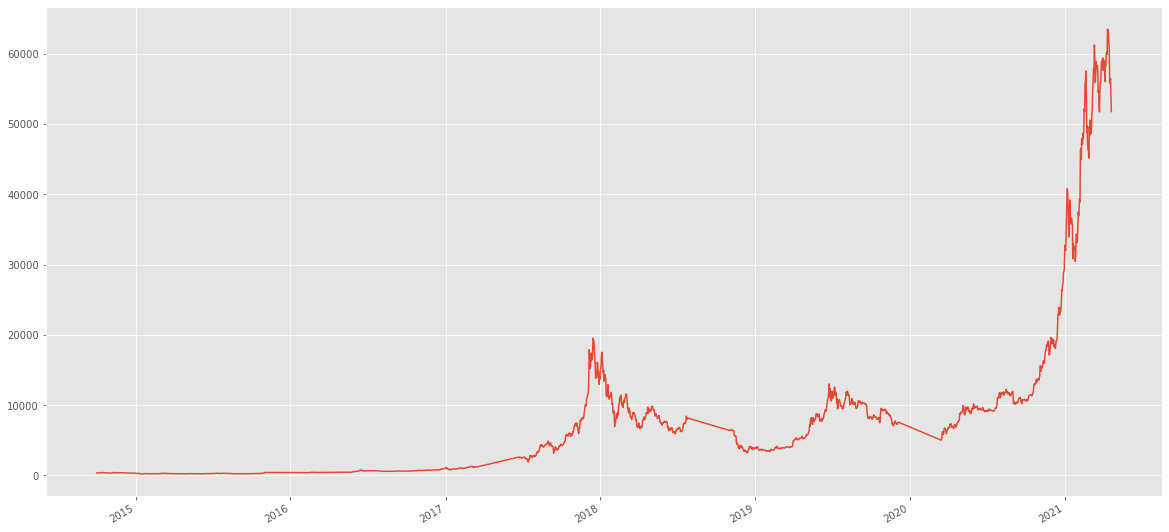

In [457]:
list(dict_train.values())[0]['Close'].plot.line()

In [458]:
list(dict_test.values())[0]

Close  1: ln(C/C-1)  2: ln(C-1/C-2)  3: ln(C-2/C-3)  \
2015-11-05    374.470001     -0.063208        0.019991        0.110569   
2015-11-06    386.481995     -0.031242       -0.063208        0.019991   
2015-11-07    373.368011      0.031574       -0.031242       -0.063208   
2015-11-08    380.256989     -0.034521        0.031574       -0.031242   
2015-11-09    336.819000      0.018283       -0.034521        0.031574   
...                  ...           ...             ...             ...   
2021-08-02  38152.980469     -0.019525       -0.040478       -0.014533   
2021-08-03  39747.503906     -0.027122       -0.019525       -0.040478   
2021-08-04  40869.554688      0.040943       -0.027122       -0.019525   
2021-08-05  42816.500000      0.027838        0.040943       -0.027122   
2021-08-06  44555.800781      0.046538        0.027838        0.040943   

            4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  7: ln(H/O-2)  \
2015-11-05        0.104251    0.092357      0.103230      0.212520   
2015-11-06        0.110569    0.019874     -0.030456     -0.019583   
2015-11-07        0.019991    0.042673      0.006522     -0.043808   
2015-11-08       -0.063208    0.014511      0.040903      0.004751   
2015-11-09       -0.031242    0.028843      0.002599      0.028990   
...                    ...         ...           ...           ...   
2021-08-02        0.054172    0.012746     -0.025445     -0.043028   
2021-08-03       -0.014533    0.014485     -0.003948     -0.042139   
2021-08-04       -0.040478    0.044502      0.019561      0.001128   
2021-08-05       -0.019525    0.039405      0.078693      0.053752   
2021-08-06       -0.027122    0.057203      0.085026      0.124313   

            8: ln(H/O-3)  9: ln(H-1/O-1)  10: ln(H-2/O-2)  11: ln(H-3/O-3)  \
2015-11-05      0.317093        0.205110         0.143949         0.114164   
2015-11-06      0.089707        0.092357         0.205110         0.143949   
2015-11-07     -0.032935        0.019874         0.092357         0.205110   
2015-11-08     -0.045578        0.042673         0.019874         0.092357   
2015-11-09     -0.007161        0.014511         0.042673         0.019874   
...                  ...             ...              ...              ...   
2021-08-02      0.009738        0.025735         0.000833         0.053696   
2021-08-03     -0.059722        0.012746         0.025735         0.000833   
2021-08-04     -0.037063        0.014485         0.012746         0.025735   
2021-08-05      0.035319        0.044502         0.014485         0.012746   
2021-08-06      0.099372        0.039405         0.044502         0.014485   

            12: ln(L/O)  13: ln(L-1/O-1)  14: ln(L-2/O-2)  15: ln(L-3/O-3)  \
2015-11-05    -0.085648        -0.058971        -0.011747        -0.008420   
2015-11-06    -0.091759        -0.085648        -0.058971        -0.011747   
2015-11-07    -0.004918        -0.091759        -0.085648        -0.058971   
2015-11-08    -0.041383        -0.004918        -0.091759        -0.085648   
2015-11-09    -0.031008        -0.041383        -0.004918        -0.091759   
...                 ...              ...              ...              ...   
2021-08-02    -0.029522        -0.047413        -0.026061        -0.041578   
2021-08-03    -0.036291        -0.029522        -0.047413        -0.026061   
2021-08-04    -0.016469        -0.036291        -0.029522        -0.047413   
2021-08-05    -0.059251        -0.016469        -0.036291        -0.029522   
2021-08-06    -0.023113        -0.059251        -0.016469        -0.036291   

            16: True Range  17: ATR 14d   18: MI 10d  19: RSI 14d  
2015-11-05       72.980011    29.840208   101.054016    79.491402  
2015-11-06       41.811005    32.459494    80.682007    74.510899  
2015-11-07       18.152985    33.383994    81.863983    75.356047  
2015-11-08       21.194977    33.996922    59.513000    70.589534  
2015-11-09       22.383026    35.253568    52.241974    71.284222  
...    

<AxesSubplot:>

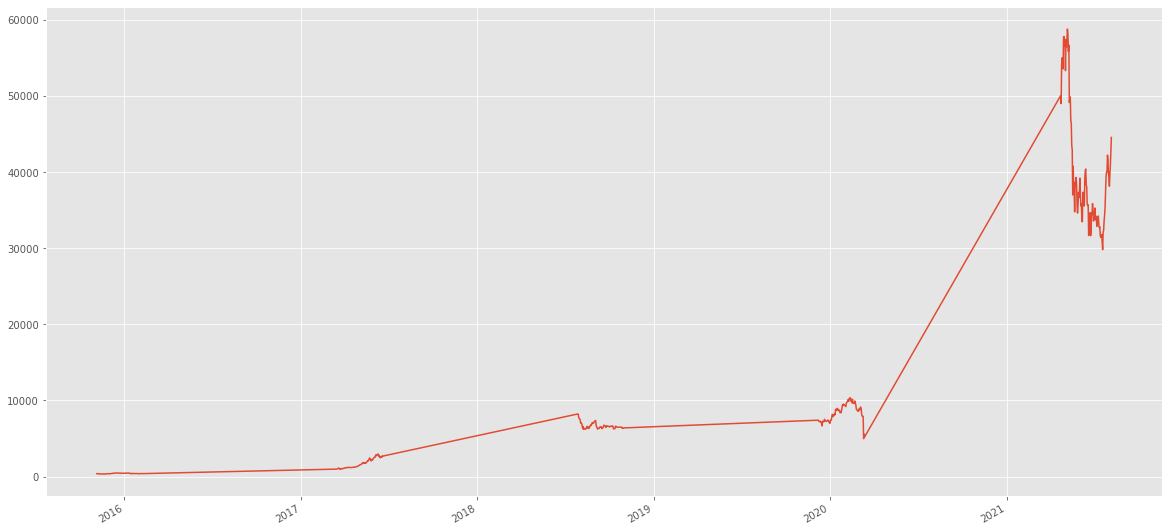

In [459]:
list(dict_test.values())[0]['Close'].plot.line()

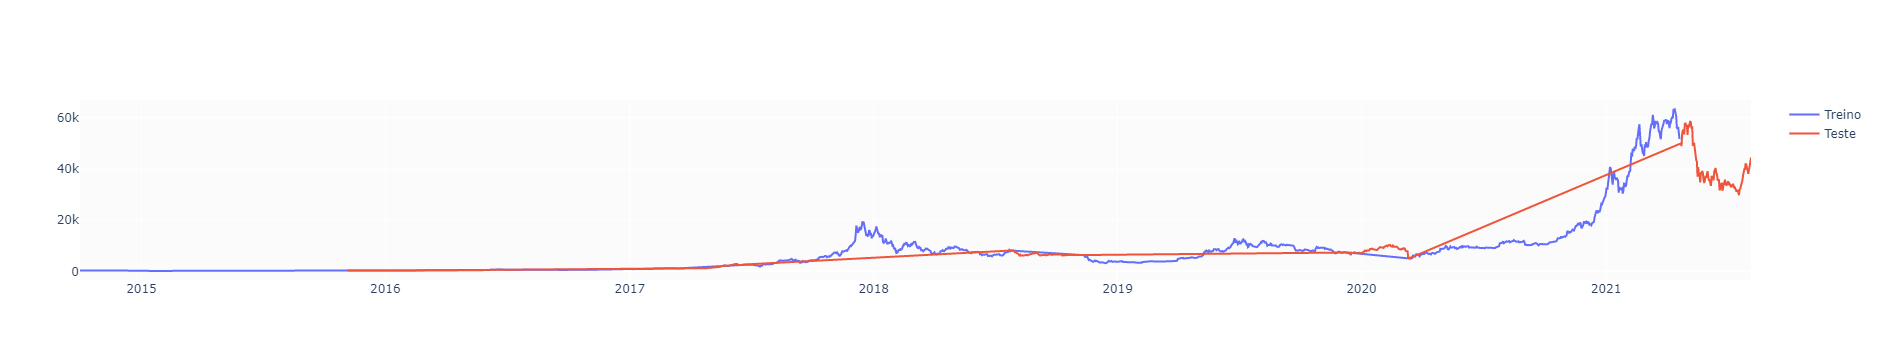

In [460]:
#Vamos ver a cara dessa bagaça e como ficaram temporalmente treino, validação e teste...
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(dict_train.values())[0].index, y=list(dict_train.values())[0].Close, name='Treino'))
fig.add_trace(go.Scatter(x=list(dict_test.values())[0].index,  y=list(dict_test.values())[0].Close,  name='Teste'))
fig.show()

In [461]:
#Vamos checar as variáveis de entrada para o primeiro ativo
list(dict_X_train.values())[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1995 entries, 2014-10-01 to 2021-04-21
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1: ln(C/C-1)     1995 non-null   float64
 1   2: ln(C-1/C-2)   1995 non-null   float64
 2   3: ln(C-2/C-3)   1995 non-null   float64
 3   4: ln(C-3/C-4)   1995 non-null   float64
 4   5: ln(H/O)       1995 non-null   float64
 5   6: ln(H/O-1)     1995 non-null   float64
 6   7: ln(H/O-2)     1995 non-null   float64
 7   8: ln(H/O-3)     1995 non-null   float64
 8   9: ln(H-1/O-1)   1995 non-null   float64
 9   10: ln(H-2/O-2)  1995 non-null   float64
 10  11: ln(H-3/O-3)  1995 non-null   float64
 11  12: ln(L/O)      1995 non-null   float64
 12  13: ln(L-1/O-1)  1995 non-null   float64
 13  14: ln(L-2/O-2)  1995 non-null   float64
 14  15: ln(L-3/O-3)  1995 non-null   float64
 15  16: True Range   1995 non-null   float64
 16  17: ATR 14d      1995 non-null   float64
 

# Vamos comparar alguns modelos, sem tunning, para ver no que dá. Vamos considerar também um modelo vagabundo, que prevê o "Close" de amanhã igual ao fechamento de hoje.

In [462]:

# Importanto as libs:


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBClassifier

# O teste mais vagabundo (dica do Mario): Prever a saída como o resultado do dia anterior:

y_pred_vagabundo = list(dict_y_test.values())[0].shift(1).dropna()

MAPE_test_vag = np.mean(np.abs((list(dict_y_test.values())[0][1:] - y_pred_vagabundo)/y_pred_vagabundo))
MSE_test_vag = mean_squared_error(list(dict_y_test.values())[0][1:], y_pred_vagabundo, squared = False)
MAE_test_vag = mean_absolute_error(list(dict_y_test.values())[0][1:], y_pred_vagabundo)
RMSE_test_vag = mean_squared_error(list(dict_y_test.values())[0][1:], y_pred_vagabundo, squared = True)



print (f"Resultados daquele 1% vagabundo:\n")
print(f'MAPE = {MAPE_test_vag:.4f}')
print(f'MSE = {MSE_test_vag:.4f}')
print(f'MAE = {MAE_test_vag:.4f}')
print(f'RMSE = {RMSE_test_vag:.4f}')
print("\n")


# Instanciando os modelos:

linear = LinearRegression()
forest = RandomForestRegressor(random_state=248)
svm = SVR(kernel="linear")
xboost = XGBClassifier(random_state=248)

# now, create a list with the objects 
models= [linear, forest, svm, xboost]

for model in models:
    model.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0]) 
    y_pred = model.predict(list(dict_X_test.values())[0]) 
    
    
    MAPE_test = np.mean(np.abs((list(dict_y_test.values())[0] - y_pred)/y_pred))
    MSE_test = mean_squared_error(list(dict_y_test.values())[0], y_pred, squared = False)
    MAE_test = mean_absolute_error(list(dict_y_test.values())[0], y_pred)
    RMSE_test = mean_squared_error(list(dict_y_test.values())[0], y_pred, squared = True)
    


    print (f"Resultados do modelo {type(model).__name__} no teste:\n")
    print(f'MAPE = {MAPE_test:.4f}')
    print(f'MSE = {MSE_test:.4f}')
    print(f'MAE = {MAE_test:.4f}')
    print(f'RMSE = {RMSE_test:.4f}')
    print("\n")

Resultados daquele 1% vagabundo:

MAPE = 0.0513
MSE = 2239.6490
MAE = 486.7374
RMSE = 5016027.7728


Resultados do modelo LinearRegression no teste:

MAPE = 1.2905
MSE = 5632.2147
MAE = 3171.9324
RMSE = 31721842.3813


Resultados do modelo RandomForestRegressor no teste:

MAPE = 0.2798
MSE = 5642.5204
MAE = 2931.7560
RMSE = 31838036.9818


Resultados do modelo SVR no teste:

MAPE = 0.6445
MSE = 6287.8881
MAE = 3644.2781
RMSE = 39537536.5140


[20:30:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Resultados do modelo XGBClassifier no teste:

MAPE = 5.5635
MSE = 14945.5160
MAE = 8398.0469
RMSE = 223368449.9987




# Definindo uma função para rodar modelo, mostrar resultados e plotar feature importance, além de armazenar tudo num DF:

In [463]:
cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
cols_results = ['MAPE_train', 'MAPE_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'RMSE_train', 'RMSE_test']
cols_params.extend(cols_results)
df_model = pd.DataFrame(columns = cols_params)
df_model

Empty DataFrame
Columns: [learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, MAPE_train, MAPE_test, MSE_train, MSE_test, MAE_train, MAE_test, RMSE_train, RMSE_test]
Index: []

In [464]:
# Créditos: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

def model_fit(estimator, dtrain, dtest, features, target, dmodel, cv_folds=10, early_stopping_rounds=50):
    
    xgb_param = estimator.get_xgb_params()
    
    xgtrain = xgb.DMatrix(data = dtrain[features].values, label = dtrain[target].values)
    
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = estimator.get_params()['n_estimators'], nfold = cv_folds,
                      metrics ='rmse', early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
    
    estimator.set_params(n_estimators=cvresult.shape[0])
    
  
        
    
    #Fit the algorithm on the data
    
    estimator.fit(dtrain[features], dtrain[target], eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = estimator.predict(dtrain[features])
    
        
    #Printar resultados no treino:
    print ("\nResultados do modelo no treino")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(df_train['Disbursed'].values, df_train_predictions))
    
    #MAPE = mean_absolute_percentage_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_train = np.mean(np.abs((dtrain[target].values - dtrain_predictions)/dtrain[target].values))
    MSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = False)
    MAE_train = mean_absolute_error(y_true = dtrain[target].values, y_pred = dtrain_predictions)
    RMSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = True)
    
    print(f'MAPE = {MAPE_train:.4f}')
    print(f'MSE = {MSE_train:.4f}')
    print(f'MAE = {MAE_train:.4f}')
    print(f'RMSE = {RMSE_train:.4f}')
    
    
    #Prever e printar resultados no teste:
    
    dtest_predictions = estimator.predict(dtest[features])
    
    #MAPE = mean_absolute_percentage_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_test = np.mean(np.abs((dtest[target].values - dtest_predictions)/dtest[target].values))
    MSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = False)
    MAE_test = mean_absolute_error(y_true = dtest[target].values, y_pred = dtest_predictions)
    RMSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = True)

    print ("\nResultados do modelo no teste")
    print(f'MAPE = {MAPE_test:.4f}')
    print(f'MSE = {MSE_test:.4f}')
    print(f'MAE = {MAE_test:.4f}')
    print(f'RMSE = {RMSE_test:.4f}')
    
   
    
    #Plotar gráfico treino e teste:
    
    print ("\n")
    print ("Time Series de treino e teste:")

    plt.rcParams["figure.figsize"] = (100, 20)
    fig = make_subplots(rows=3, cols=1, )

    fig.add_trace(go.Scatter(x = dtrain.index, y = dtrain[target].values,
                             name='Real - Treino',
                             marker_color='Green'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtrain.index,
                             y = dtrain_predictions,
                             name='Predição - Treino',
                             marker_color='DarkBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtest.index, y = dtest[target].values,
                             name='Real - Teste',
                             marker_color='Green'), row=3, col=1)

    fig.add_trace(go.Scatter(x = dtest.index,
                             y = dtest_predictions,
                             name='Predição - Teste',
                             marker_color='DarkBlue'), row=3, col=1)

    fig.show()
    
     
    #Plotar feature importance:
    
    print ("\n")
    plt.rcParams["figure.figsize"] = (20, 10)
    plot_importance(estimator, height = 0.5)
    
    #Armazenando os parâmetros e resultados em um DF:
    
    params_results = []
    
    cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
    cols_results = ['MAPE_train', 'MAPE_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'RMSE_train', 'RMSE_test']
    
    for i in range(len(cols_params)):
        params_results.append(estimator.get_params()[cols_params[i]])
    
    params_results.extend([MAPE_train, MAPE_test, MSE_train, MSE_test, MAE_train, MAE_test, RMSE_train, RMSE_test])
    
    dmodel.loc[len(dmodel)] = params_results
    print ("DataFrame consolidado de parâmetros e resultados tentados até aqui:")
    
    return dmodel
    print ("\n")
    

## Step 1: Fix learning rate (aka "eta") and number of estimators for tuning tree-based parameters

[0]	train-rmse:12277.63301+113.29323	test-rmse:12258.82275+1030.12346
[1]	train-rmse:11152.43564+90.77265	test-rmse:11161.82246+975.86830
[2]	train-rmse:10143.21338+86.92779	test-rmse:10184.69541+883.94999
[3]	train-rmse:9222.03936+85.43848	test-rmse:9291.57715+809.88270
[4]	train-rmse:8410.82207+83.30279	test-rmse:8485.75947+757.64342
[5]	train-rmse:7682.51885+89.36401	test-rmse:7783.60020+686.93430
[6]	train-rmse:7023.77017+106.50813	test-rmse:7156.38853+654.00084
[7]	train-rmse:6432.42759+101.69165	test-rmse:6589.58345+624.92222
[8]	train-rmse:5881.59556+97.30324	test-rmse:6090.91040+583.53395
[9]	train-rmse:5392.16479+86.98336	test-rmse:5660.28560+559.28943
[10]	train-rmse:4955.15264+82.05977	test-rmse:5268.78262+545.31613
[11]	train-rmse:4555.32622+77.79309	test-rmse:4921.80117+524.85351
[12]	train-rmse:4194.76018+74.46035	test-rmse:4612.16814+509.01846
[13]	train-rmse:3874.28911+67.32013	test-rmse:4347.68474+475.29180
[14]	train-rmse:3583.15251+61.45566	test-rmse:4097.60984+457.6

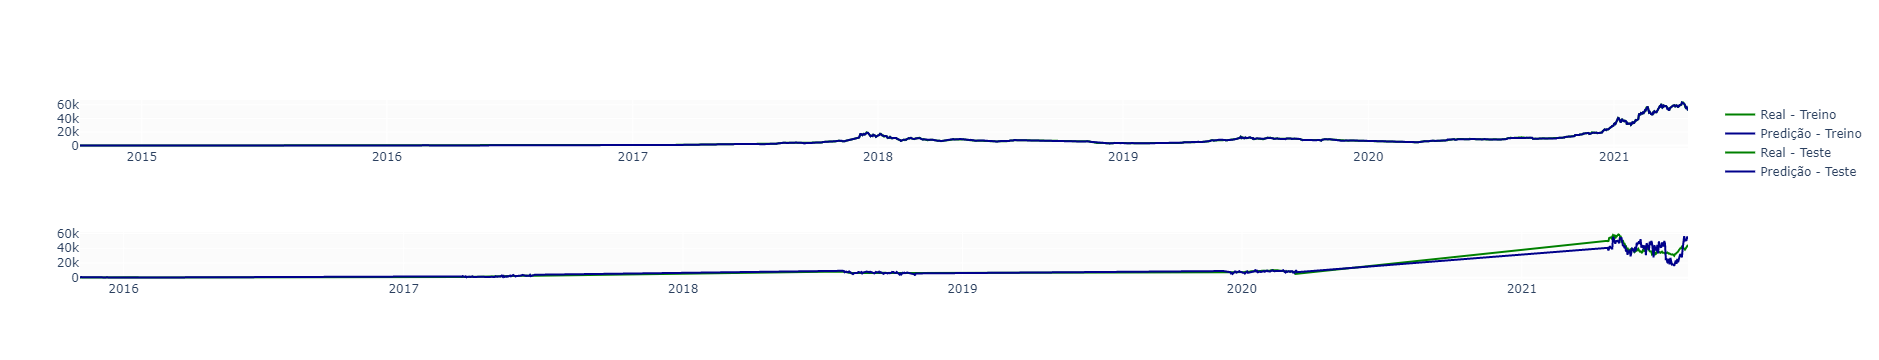



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0            0.1         368.0        5.0               1.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  MSE_train  \
0               0.8        0.0         1.0    0.047017   0.201128  91.487656   

      MSE_test  MAE_train     MAE_test   RMSE_train     RMSE_test  
0  4472.302968  66.536871  2231.827463  8369.991275  2.000149e+07

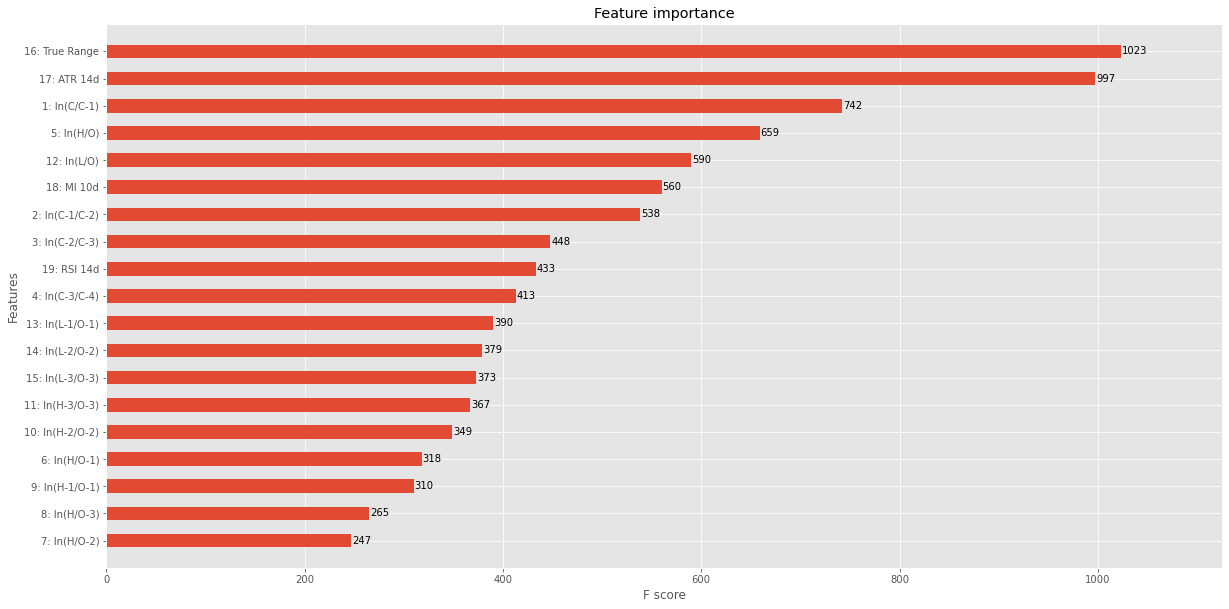

In [465]:
#Vamos setar learning_rate para 0.1 e n_etimators para 1000. A ideia é tunar apenas os parâmetros específicos de árvores, que vão começar como segue:

xgb1 = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         colsample_bytree=0.8,
         subsample = 0.8,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb1, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

Como o erro continuou caindo até o 368º estimador, vamos atribuir esse valor a n_estimator. Percebemos que há claramente um overfitting quando observamos a série temporal de treino.

## Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [466]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,8,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=5,
                         min_child_weight=1, gamma=0, colsample_bytree=0.8, subsample = 0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test1, n_jobs= -1, cv=5, verbose=2)

gsearch1.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch1.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   36.8s finished


([{'max_depth': 3, 'min_child_weight': 1},
  {'max_depth': 3, 'min_child_weight': 3},
  {'max_depth': 3, 'min_child_weight': 5},
  {'max_depth': 3, 'min_child_weight': 7},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 3},
  {'max_depth': 5, 'min_child_weight': 5},
  {'max_depth': 5, 'min_child_weight': 7},
  {'max_depth': 7, 'min_child_weight': 1},
  {'max_depth': 7, 'min_child_weight': 3},
  {'max_depth': 7, 'min_child_weight': 5},
  {'max_depth': 7, 'min_child_weight': 7},
  {'max_depth': 9, 'min_child_weight': 1},
  {'max_depth': 9, 'min_child_weight': 3},
  {'max_depth': 9, 'min_child_weight': 5},
  {'max_depth': 9, 'min_child_weight': 7}],
 {'max_depth': 7, 'min_child_weight': 7},
 -4.6173475366837895)

Encontramos os melhores valores. Para aprofundar, vamos aumentar a granularidade do teste variando os best_params em +1 e -1.

In [467]:
param_test2 = {
 'max_depth':[6, 7, 8],
 'min_child_weight':[6, 7, 8]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=7,
                         min_child_weight=7, gamma=0, colsample_bytree=0.8, subsample = 0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test2, n_jobs= -1, cv=5, verbose=2)

gsearch2.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch2.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.4s finished


([{'max_depth': 6, 'min_child_weight': 6},
  {'max_depth': 6, 'min_child_weight': 7},
  {'max_depth': 6, 'min_child_weight': 8},
  {'max_depth': 7, 'min_child_weight': 6},
  {'max_depth': 7, 'min_child_weight': 7},
  {'max_depth': 7, 'min_child_weight': 8},
  {'max_depth': 8, 'min_child_weight': 6},
  {'max_depth': 8, 'min_child_weight': 7},
  {'max_depth': 8, 'min_child_weight': 8}],
 {'max_depth': 7, 'min_child_weight': 7},
 -4.6173475366837895)

Permanecemos com os valores encontrados como os melhores parâmetros.

## Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. 

In [468]:
param_test3 = {
 'gamma':[i/10 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=7,
                         min_child_weight=7, gamma=0, colsample_bytree=0.8, subsample = 0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test3, n_jobs= -1, cv=5, verbose=2)

gsearch3.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch3.cv_results_['params'], gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.6s finished


([{'gamma': 0.0},
  {'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4},
  {'gamma': 0.5},
  {'gamma': 0.6},
  {'gamma': 0.7},
  {'gamma': 0.8},
  {'gamma': 0.9}],
 {'gamma': 0.0},
 -4.6173475366837895)

gamma = 0.0 se mostrou um bom valor. Agora que fizemos esse passo, é importante reavaliar o n_estimators. Vamos lá:

[0]	train-rmse:12278.31807+114.16553	test-rmse:12254.21406+1045.05328
[1]	train-rmse:11145.45449+89.98035	test-rmse:11124.46133+974.51670
[2]	train-rmse:10132.95332+89.71249	test-rmse:10121.35400+888.84577
[3]	train-rmse:9210.31357+86.28254	test-rmse:9218.81611+828.44758
[4]	train-rmse:8393.36777+80.44617	test-rmse:8422.74790+758.24092
[5]	train-rmse:7664.04829+89.67448	test-rmse:7707.94019+712.67811
[6]	train-rmse:6998.85254+104.73005	test-rmse:7071.82476+680.93935
[7]	train-rmse:6400.24595+99.14442	test-rmse:6512.45933+630.75343
[8]	train-rmse:5844.12456+92.14991	test-rmse:5996.95234+588.66077
[9]	train-rmse:5349.48574+85.01152	test-rmse:5539.19253+562.51044
[10]	train-rmse:4906.69063+82.11143	test-rmse:5152.96924+562.33582
[11]	train-rmse:4506.02275+81.07882	test-rmse:4799.48945+534.72428
[12]	train-rmse:4141.28750+72.45733	test-rmse:4488.54751+523.31634
[13]	train-rmse:3818.39448+65.08903	test-rmse:4222.04495+495.94333
[14]	train-rmse:3524.72219+60.87273	test-rmse:3976.28240+488.43

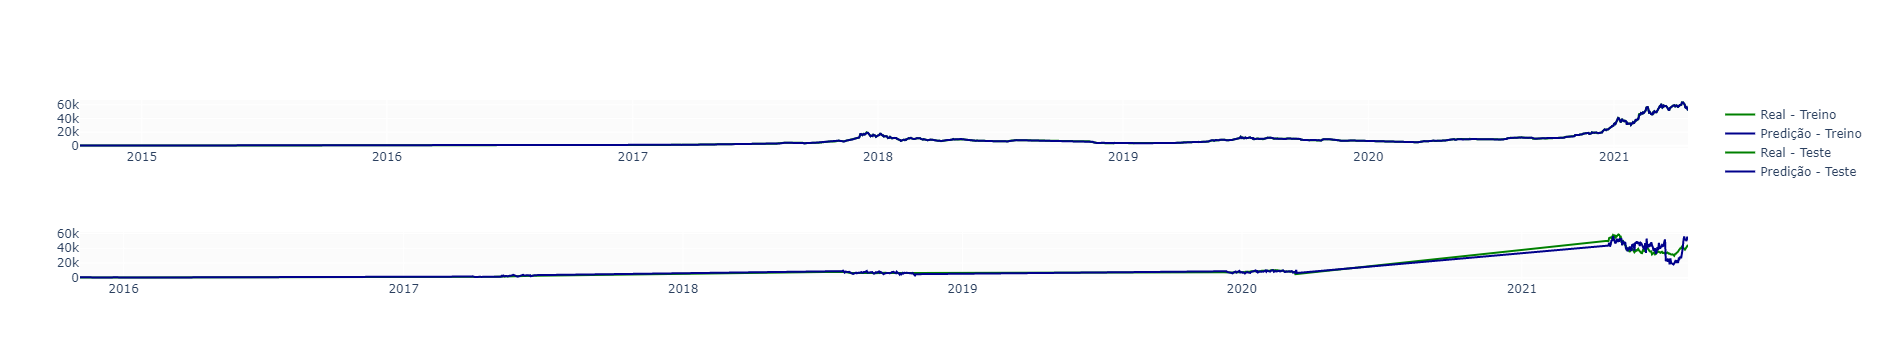



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0            0.1         368.0        5.0               1.0    0.0        0.8   
1            0.1         368.0        7.0               7.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  MSE_train  \
0               0.8        0.0         1.0    0.047017   0.201128  91.487656   
1               0.8        0.0         1.0    0.028858   0.196982  52.814231   

      MSE_test  MAE_train     MAE_test   RMSE_train     RMSE_test  
0  4472.302968  66.536871  2231.827463  8369.991275  2.000149e+07  
1  4213.993190  36.528834  2103.074258  2789.342984  1.775774e+07

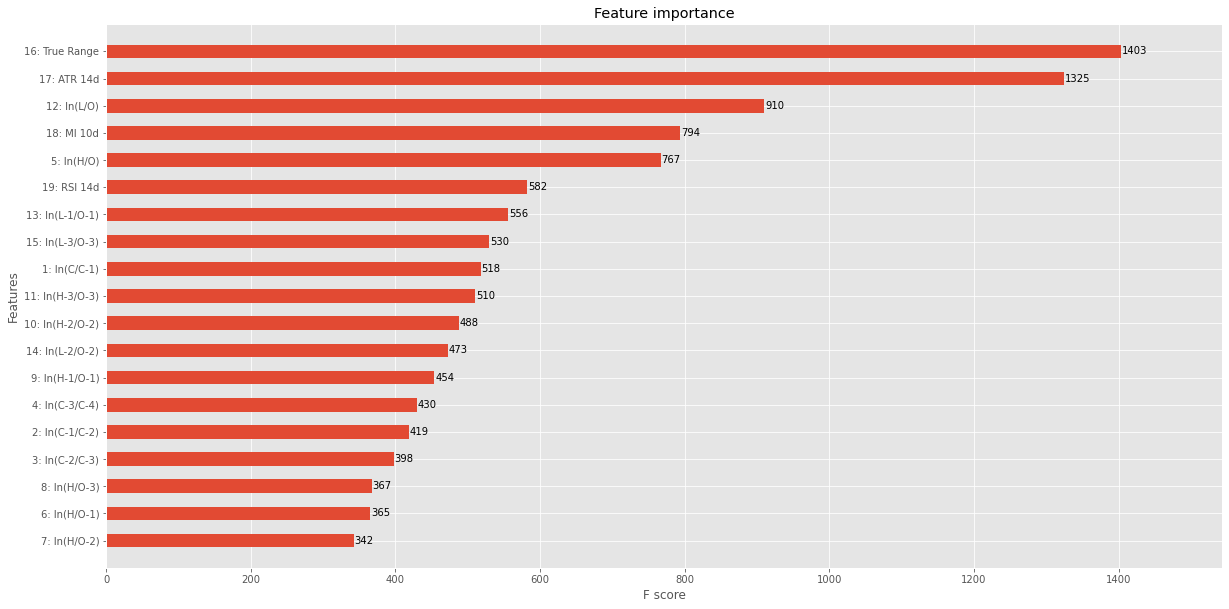

In [469]:
xgb2 = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=368,
         max_depth=7,
         min_child_weight=7,
         gamma=0.0,
         colsample_bytree=0.8,
         subsample = 0.8,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb2, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

"n_estimators" deve continumar com o valor 368, já que o aumento da quantidade de árvores não se justifica pela diminuição no erro.

## Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [470]:
param_test4 = {
 'subsample':[i/10 for i in range(6,10)],
 'colsample_bytree':[i/10 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=7,
                         min_child_weight=7, gamma=0.0, subsample = 0.8, colsample_bytree=0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test4, n_jobs= -1, cv=5, verbose=2)

gsearch4.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch4.cv_results_['params'], gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   39.1s finished


([{'colsample_bytree': 0.6, 'subsample': 0.6},
  {'colsample_bytree': 0.6, 'subsample': 0.7},
  {'colsample_bytree': 0.6, 'subsample': 0.8},
  {'colsample_bytree': 0.6, 'subsample': 0.9},
  {'colsample_bytree': 0.7, 'subsample': 0.6},
  {'colsample_bytree': 0.7, 'subsample': 0.7},
  {'colsample_bytree': 0.7, 'subsample': 0.8},
  {'colsample_bytree': 0.7, 'subsample': 0.9},
  {'colsample_bytree': 0.8, 'subsample': 0.6},
  {'colsample_bytree': 0.8, 'subsample': 0.7},
  {'colsample_bytree': 0.8, 'subsample': 0.8},
  {'colsample_bytree': 0.8, 'subsample': 0.9},
  {'colsample_bytree': 0.9, 'subsample': 0.6},
  {'colsample_bytree': 0.9, 'subsample': 0.7},
  {'colsample_bytree': 0.9, 'subsample': 0.8},
  {'colsample_bytree': 0.9, 'subsample': 0.9}],
 {'colsample_bytree': 0.9, 'subsample': 0.8},
 -4.306001341352102)

Agora que encontramos os melhores valores, vamos aumentar a granularidade para 0.05 e observar:

In [471]:
param_test5 = {
 'subsample':[i/100 for i in range(75,90,5)],
 'colsample_bytree':[i/100 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=7,
                         min_child_weight=7, gamma=0.0, subsample = 0.8, colsample_bytree=0.8,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test5, n_jobs= -1, cv=5, verbose=2)

gsearch5.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch5.cv_results_['params'], gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.2s finished


([{'colsample_bytree': 0.85, 'subsample': 0.75},
  {'colsample_bytree': 0.85, 'subsample': 0.8},
  {'colsample_bytree': 0.85, 'subsample': 0.85},
  {'colsample_bytree': 0.9, 'subsample': 0.75},
  {'colsample_bytree': 0.9, 'subsample': 0.8},
  {'colsample_bytree': 0.9, 'subsample': 0.85},
  {'colsample_bytree': 0.95, 'subsample': 0.75},
  {'colsample_bytree': 0.95, 'subsample': 0.8},
  {'colsample_bytree': 0.95, 'subsample': 0.85}],
 {'colsample_bytree': 0.9, 'subsample': 0.8},
 -4.306001341352102)

Valores não se alteraram. Definimos, então:
colsample_bytree = 0.9 ;
subsample = 0.8

# >>>Vamos dar um passo aqui: Setar o Learning_rate [https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f]

## Step 5: Tuning Regularization Parameters
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [472]:
param_test6 = {
 'reg_alpha':[0, 1e-4, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=7,
                         min_child_weight=7, gamma=0.0, subsample = 0.8, colsample_bytree=0.9,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test6, n_jobs= -1, cv=5, verbose=2)

gsearch6.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch6.cv_results_['params'], gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.2s finished


([{'reg_alpha': 0},
  {'reg_alpha': 0.0001},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1},
  {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 -4.256315368591571)

Aparentemente, o alpha ideal deve ser pequeno, da ordem de 0.1. Vamos explorar um pouco mais aumentando a granularidade:

In [473]:
param_test7 = {
 'reg_alpha':[8e-2, 5e-2, 1e-1, 3e-1, 5e-1]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=368, max_depth=7,
                         min_child_weight=7, gamma=0.0, subsample = 0.8, colsample_bytree=0.9,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test7, n_jobs= -1, cv=5, verbose=2)

gsearch7.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch7.cv_results_['params'], gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.6s finished


([{'reg_alpha': 0.08},
  {'reg_alpha': 0.05},
  {'reg_alpha': 0.1},
  {'reg_alpha': 0.3},
  {'reg_alpha': 0.5}],
 {'reg_alpha': 0.05},
 -4.219488145025067)

reg_alpha = 0.05 confirmou ser o melhor valor.
Agora vamos rodar mais uma vez o modelo, dessa vez aumentando o n_estimators para avaliar o número ideal:

[0]	train-rmse:12278.25742+114.18510	test-rmse:12254.58457+1045.52806
[1]	train-rmse:11143.04307+90.84890	test-rmse:11128.55566+976.42580
[2]	train-rmse:10126.49229+92.38399	test-rmse:10137.48057+897.69447
[3]	train-rmse:9205.30625+88.03952	test-rmse:9235.64434+837.05489
[4]	train-rmse:8375.21543+75.32373	test-rmse:8422.90400+780.33744
[5]	train-rmse:7631.79795+68.75907	test-rmse:7694.47676+732.51386
[6]	train-rmse:6956.51499+62.27994	test-rmse:7036.17915+681.40918
[7]	train-rmse:6360.29590+61.70401	test-rmse:6452.62285+630.15715
[8]	train-rmse:5809.30830+57.97038	test-rmse:5935.14497+597.46630
[9]	train-rmse:5318.28086+52.71015	test-rmse:5494.58945+564.93592
[10]	train-rmse:4878.00957+53.89733	test-rmse:5086.91479+538.22921
[11]	train-rmse:4477.91860+52.78173	test-rmse:4754.52480+509.44532
[12]	train-rmse:4119.82539+49.46146	test-rmse:4459.28865+491.62384
[13]	train-rmse:3795.46355+46.57937	test-rmse:4188.42683+470.72028
[14]	train-rmse:3502.65352+43.84656	test-rmse:3952.97317+456.678

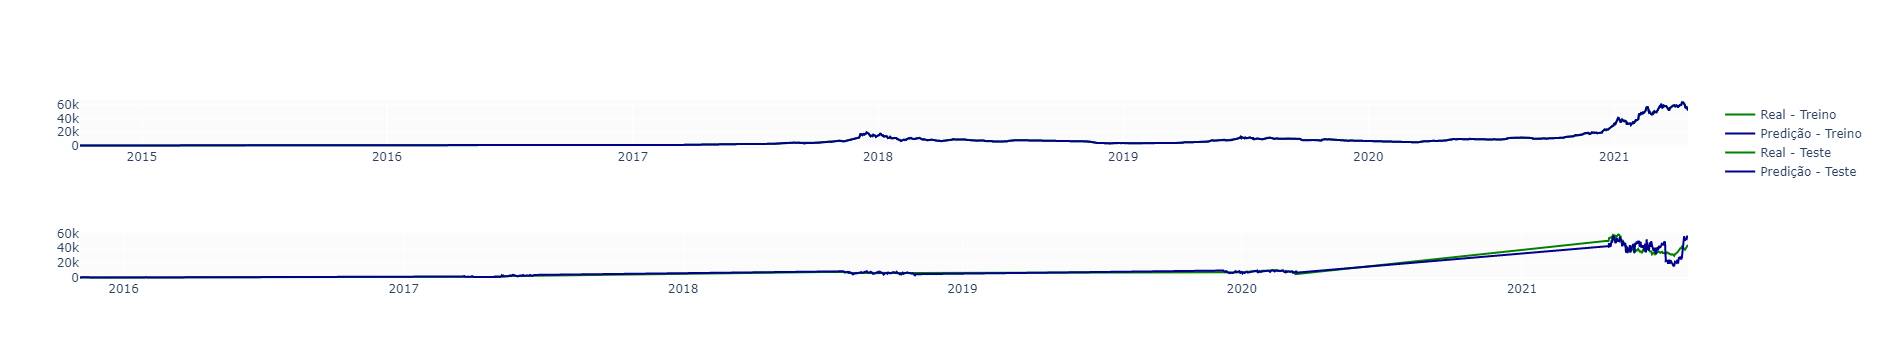



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0            0.1         368.0        5.0               1.0    0.0        0.8   
1            0.1         368.0        7.0               7.0    0.0        0.8   
2            0.1         534.0        7.0               7.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  MSE_train  \
0               0.8       0.00         1.0    0.047017   0.201128  91.487656   
1               0.8       0.00         1.0    0.028858   0.196982  52.814231   
2               0.9       0.05         1.0    0.008663   0.195569  12.494121   

      MSE_test  MAE_train     MAE_test   RMSE_train     RMSE_test  
0  4472.302968  66.536871  2231.827463  8369.991275  2.000149e+07  
1  4213.993190  36.528834  2103.074258  2789.342984  1.775774e+07  
2  4386.504894   8.958208  2182.083626   156.103063  1.924143e+07

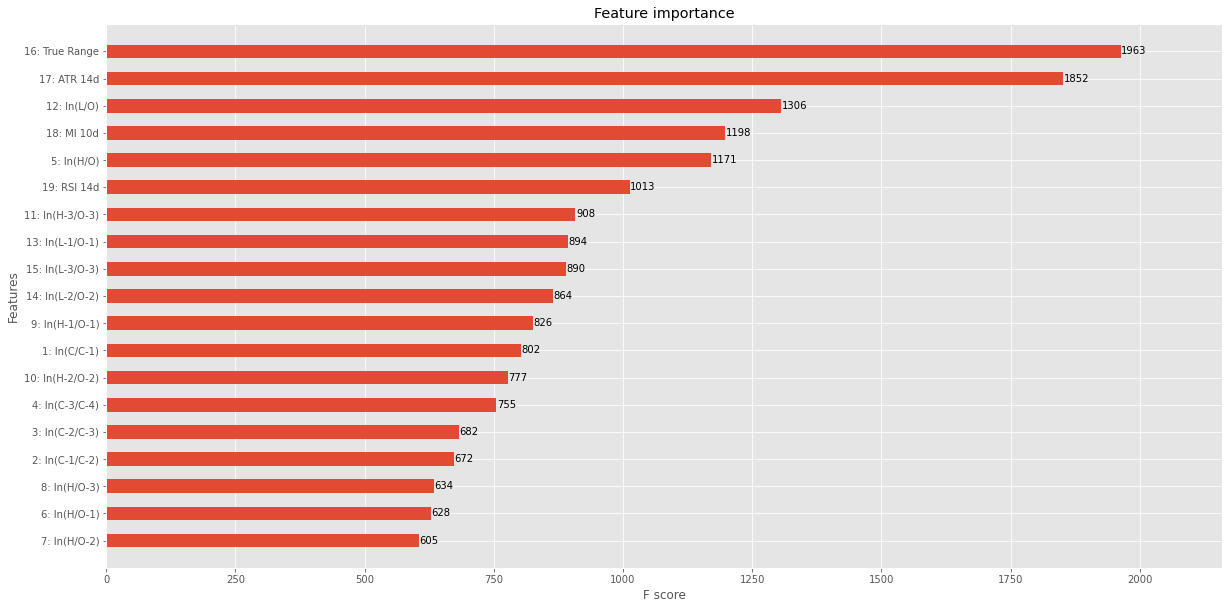

In [474]:
xgb3 = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=7,
         min_child_weight=7,
         gamma=0.0,
         colsample_bytree=0.9,
         subsample = 0.8,
         reg_alpha = 0.05,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb3, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

Ainda bastante overfitado... n_estimators poderia adotar o valor de 534. Vamos checar o reg_lambda.

### Explorando o reg_lambda:

In [475]:
param_test8 = {
 'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=534, max_depth=7,
                         min_child_weight=7, gamma=0.0, subsample = 0.8, colsample_bytree=0.9,  reg_alpha = 0.05,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test8, n_jobs= -1, cv=5, verbose=2)

gsearch8.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch8.cv_results_['params'], gsearch8.best_params_, gsearch8.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.5s finished


([{'reg_lambda': 0},
  {'reg_lambda': 1e-05},
  {'reg_lambda': 0.01},
  {'reg_lambda': 0.1},
  {'reg_lambda': 1},
  {'reg_lambda': 100}],
 {'reg_lambda': 100},
 -3.3958375214470324)

Opa... lambda 100 é o melhor valor até então. Vamos aumentar um pouco mais esse range em torno desse valor, para verificar:

In [476]:
param_test9 = {
 'reg_lambda':[90, 100, 500, 1000, 2000, 2500]
}
gsearch9 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=534, max_depth=7,
                         min_child_weight=7, gamma=0.0, subsample = 0.8, colsample_bytree=0.9,  reg_alpha = 0.05,
                         objective= 'reg:squarederror', seed=248), 
                         param_grid = param_test9, n_jobs= -1, cv=5, verbose=2)

gsearch9.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])
gsearch9.cv_results_['params'], gsearch9.best_params_, gsearch9.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.7s finished


([{'reg_lambda': 90},
  {'reg_lambda': 100},
  {'reg_lambda': 500},
  {'reg_lambda': 1000},
  {'reg_lambda': 2000},
  {'reg_lambda': 2500}],
 {'reg_lambda': 1000},
 -2.632666534768552)

Não faz muito sentido ter um lambda tão alto... Explorar isso depois

[0]	train-rmse:13420.44229+128.11091	test-rmse:13375.38545+1119.64095
[1]	train-rmse:13295.20781+125.33703	test-rmse:13250.79736+1111.91081
[2]	train-rmse:13171.78555+124.96686	test-rmse:13129.29033+1101.58747
[3]	train-rmse:13048.67373+124.01987	test-rmse:13006.57266+1093.75299
[4]	train-rmse:12926.79219+122.31661	test-rmse:12886.27900+1085.87897
[5]	train-rmse:12806.62090+120.91576	test-rmse:12768.79551+1077.69348
[6]	train-rmse:12686.73281+119.61846	test-rmse:12649.68916+1069.99287
[7]	train-rmse:12569.87617+118.81449	test-rmse:12533.24941+1061.22444
[8]	train-rmse:12452.87334+118.25325	test-rmse:12418.10967+1051.17180
[9]	train-rmse:12337.00146+116.83796	test-rmse:12303.07891+1043.70899
[10]	train-rmse:12222.66572+115.86863	test-rmse:12188.97969+1036.18440
[11]	train-rmse:12109.07139+114.85415	test-rmse:12077.60010+1028.00486
[12]	train-rmse:11996.56553+113.81468	test-rmse:11967.10352+1020.43204
[13]	train-rmse:11885.16309+112.41637	test-rmse:11856.42783+1013.16589
[14]	train-rmse:

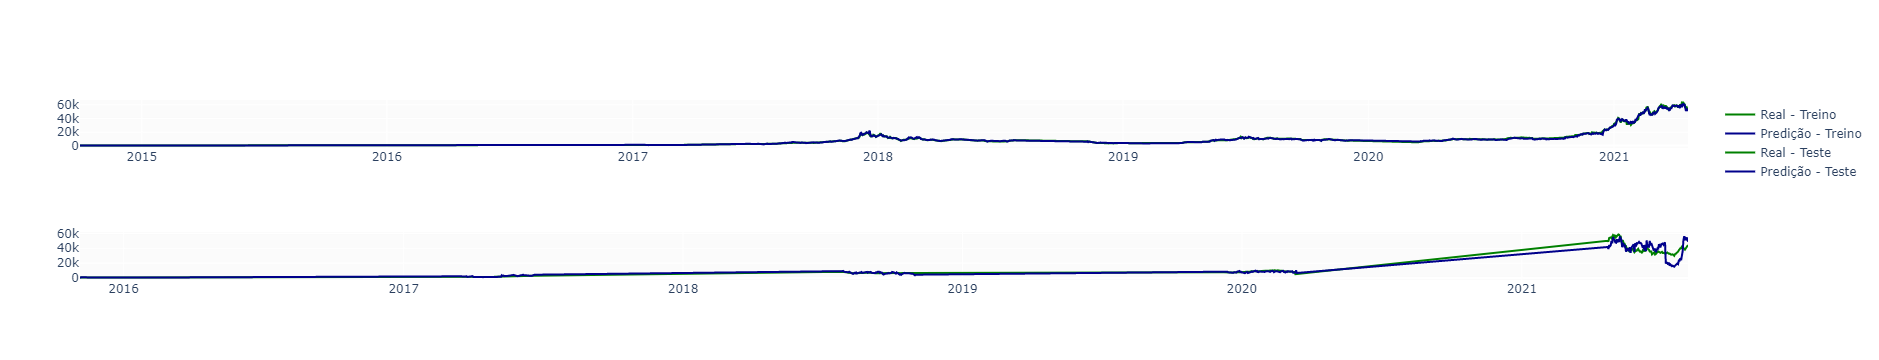



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0           0.10         368.0        5.0               1.0    0.0        0.8   
1           0.10         368.0        7.0               7.0    0.0        0.8   
2           0.10         534.0        7.0               7.0    0.0        0.8   
3           0.01         534.0        7.0               7.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test   MSE_train  \
0               0.8       0.00         1.0    0.047017   0.201128   91.487656   
1               0.8       0.00         1.0    0.028858   0.196982   52.814231   
2               0.9       0.05         1.0    0.008663   0.195569   12.494121   
3               0.9       0.05         1.0    0.097159   0.214990  639.265604   

      MSE_test   MAE_train     MAE_test     RMSE_train     RMSE_test  
0  4472.302968   66.536871  2231.827463    8369.991275  2.000149e+07  
1  4213.993190   36.528834  2103.074258    2789.342984  1.775774e+07  
2  4386.504894    8.958208  2182.083626     156.103063  1.924143e+07  
3  4714.011135  339.388774  2358.883374  408660.512608  2.222190e+07

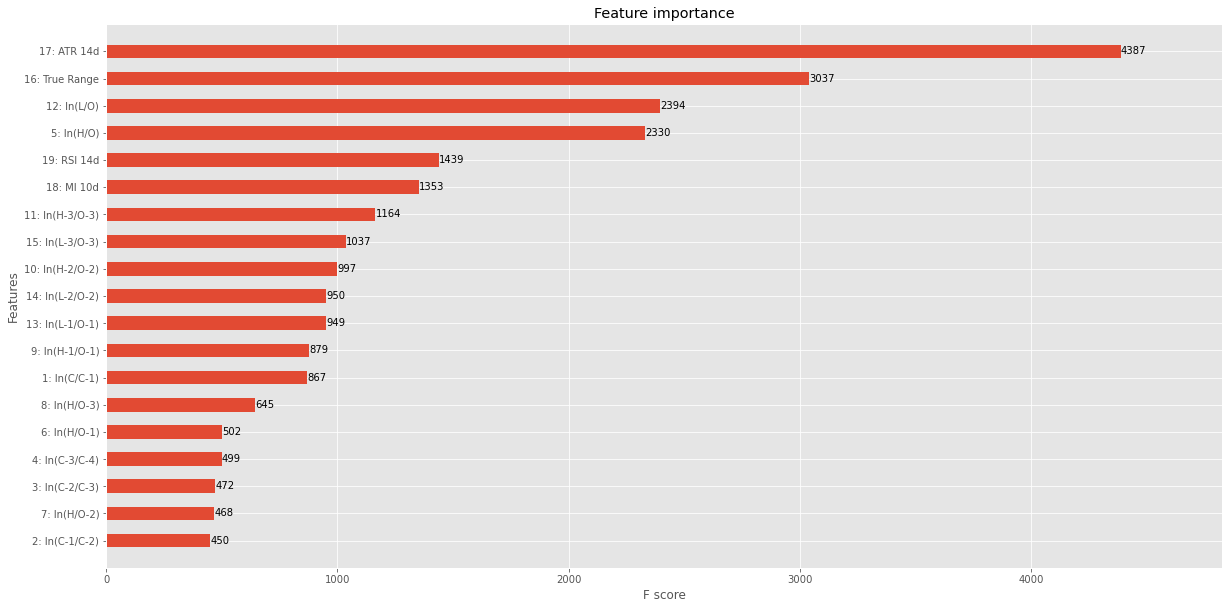

In [477]:
xgb4 = xgb.XGBRegressor(
         learning_rate =0.01,
         n_estimators=534,
         max_depth=7,
         min_child_weight=7,
         gamma=0.0,
         colsample_bytree=0.9,
         subsample = 0.8,
         reg_alpha = 0.05,
         reg_lambda = 1,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb4, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

## Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Let's use the cv function of XGBoost to do the job again.

[0]	train-rmse:13479.61006+129.20137	test-rmse:13432.28408+1126.41845
[1]	train-rmse:13410.99131+127.71512	test-rmse:13364.42783+1126.74107
[2]	train-rmse:13343.00703+126.97138	test-rmse:13296.93477+1125.23695
[3]	train-rmse:13275.72178+126.56360	test-rmse:13229.62061+1123.71127
[4]	train-rmse:13208.53115+125.48923	test-rmse:13162.90361+1122.88928
[5]	train-rmse:13142.61855+124.72439	test-rmse:13097.35928+1121.80777
[6]	train-rmse:13076.66260+124.27406	test-rmse:13031.32578+1120.19052
[7]	train-rmse:13011.98516+124.17838	test-rmse:12967.00879+1118.21641
[8]	train-rmse:12947.23272+123.05911	test-rmse:12902.91787+1117.12915
[9]	train-rmse:12882.82588+122.43865	test-rmse:12839.24629+1115.51685
[10]	train-rmse:12819.62031+121.91668	test-rmse:12776.51133+1114.49703
[11]	train-rmse:12756.95020+121.36212	test-rmse:12714.70322+1112.58657
[12]	train-rmse:12694.18057+120.56492	test-rmse:12652.53711+1110.95646
[13]	train-rmse:12632.26436+120.07797	test-rmse:12590.93877+1109.22273
[14]	train-rmse:

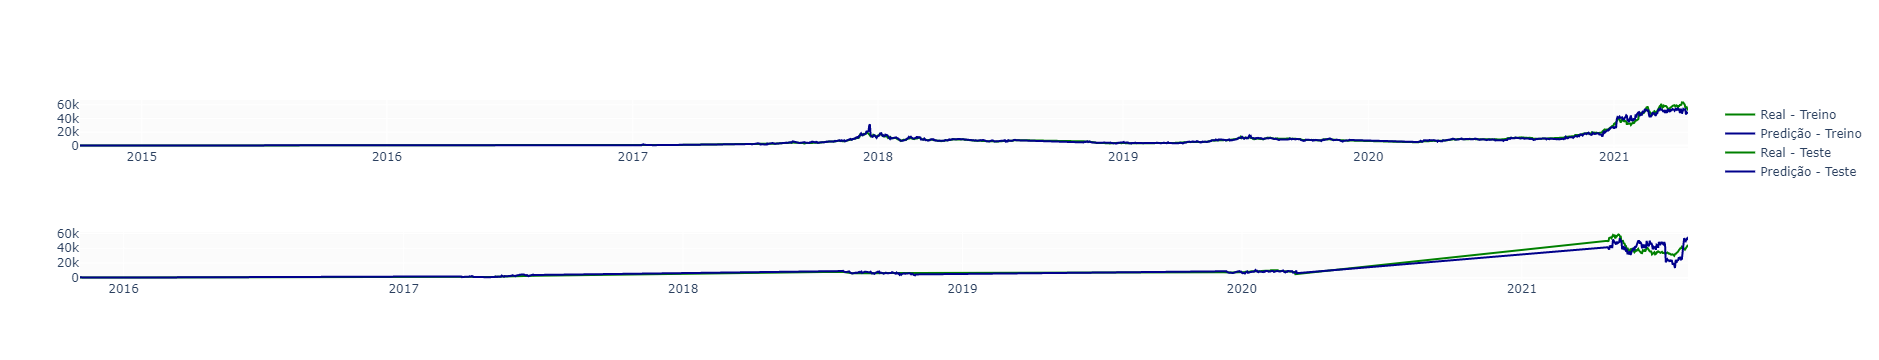



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0           0.10         368.0        5.0               1.0    0.0        0.8   
1           0.10         368.0        7.0               7.0    0.0        0.8   
2           0.10         534.0        7.0               7.0    0.0        0.8   
3           0.01         534.0        7.0               7.0    0.0        0.8   
4           0.01        1000.0        7.0               7.0    0.0        0.8   
5           0.01         534.0        7.0               7.0    0.0        0.8   
6           0.01        1000.0        7.0               7.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  \
0               0.8       0.00         1.0    0.047017   0.201128   
1               0.8       0.00         1.0    0.028858   0.196982   
2               0.9       0.05         1.0    0.008663   0.195569   
3               0.9       0.05         1.0    0.097159   0.214990   
4               0.9       0.05        50.0    0.106906   0.191463   
5               0.9       0.05         1.0    0.097159   0.214990   
6               0.9       0.05       100.0    0.118169   0.199755   

     MSE_train     MSE_test   MAE_train     MAE_test    RMSE_train  \
0    91.487656  4472.302968   66.536871  2231.827463  8.369991e+03   
1    52.814231  4213.993190   36.528834  2103.074258  2.789343e+03   
2    12.494121  4386.504894    8.958208  2182.083626  1.561031e+02   
3   639.265604  4714.011135  339.388774  2358.883374  4.086605e+05   
4  1169.497607  4563.714721  507.792921  2294.092362  1.367725e+06   
5   639.265604  4714.011135  339.388774  2358.883374  4.086605e+05   
6  1583.254660  4644.079930  673.732515  2404.528026  2.506695e+06   

      RMSE_test  
0  2.000149e+07  
1  1.775774e+07  
2  1.924143e+07  
3  2.222190e+07  
4  2.082749e+07  
5  2.222190e+07  
6  2.156748e+07

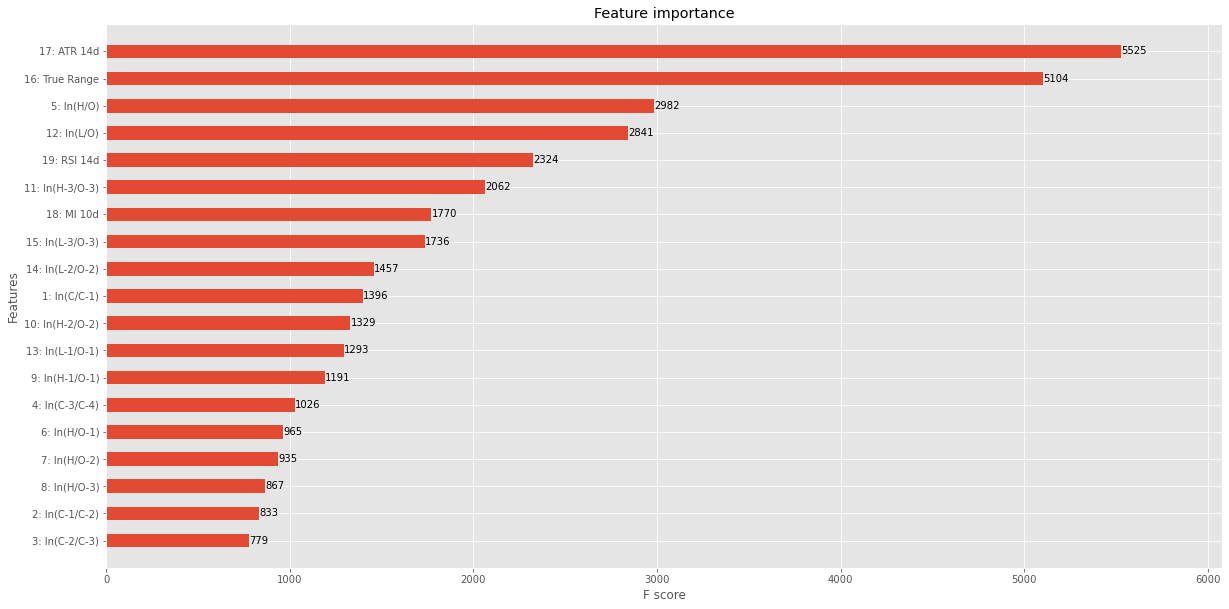

In [483]:
xgb5 = xgb.XGBRegressor(
         learning_rate =0.01,
         n_estimators=1000,
         max_depth=7,
         min_child_weight=7,
         gamma=0.0,
         colsample_bytree=0.9,
         subsample = 0.8,
         reg_alpha = 0.05,
         reg_lambda = 100,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb5, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

[0]	train-rmse:13460.26660+128.78107	test-rmse:13413.68770+1126.23125
[1]	train-rmse:13371.14697+126.73339	test-rmse:13324.27637+1124.76614
[2]	train-rmse:13283.45801+125.68220	test-rmse:13237.34033+1122.20944
[3]	train-rmse:13195.89033+125.26634	test-rmse:13149.69043+1117.51087
[4]	train-rmse:13107.79482+123.57652	test-rmse:13062.46484+1115.25033
[5]	train-rmse:13021.81367+121.48022	test-rmse:12977.26836+1111.25339
[6]	train-rmse:12935.31143+120.29358	test-rmse:12891.47148+1107.90653
[7]	train-rmse:12850.98506+119.57124	test-rmse:12807.30869+1104.93251
[8]	train-rmse:12766.57139+118.03652	test-rmse:12724.71152+1102.52476
[9]	train-rmse:12682.70117+116.86488	test-rmse:12641.14102+1099.09293
[10]	train-rmse:12600.04277+116.39726	test-rmse:12558.28252+1094.88024
[11]	train-rmse:12517.32813+115.70975	test-rmse:12475.66143+1091.42168
[12]	train-rmse:12434.83770+114.75063	test-rmse:12394.62695+1087.48953
[13]	train-rmse:12353.46953+114.03465	test-rmse:12314.56963+1083.44235
[14]	train-rmse:

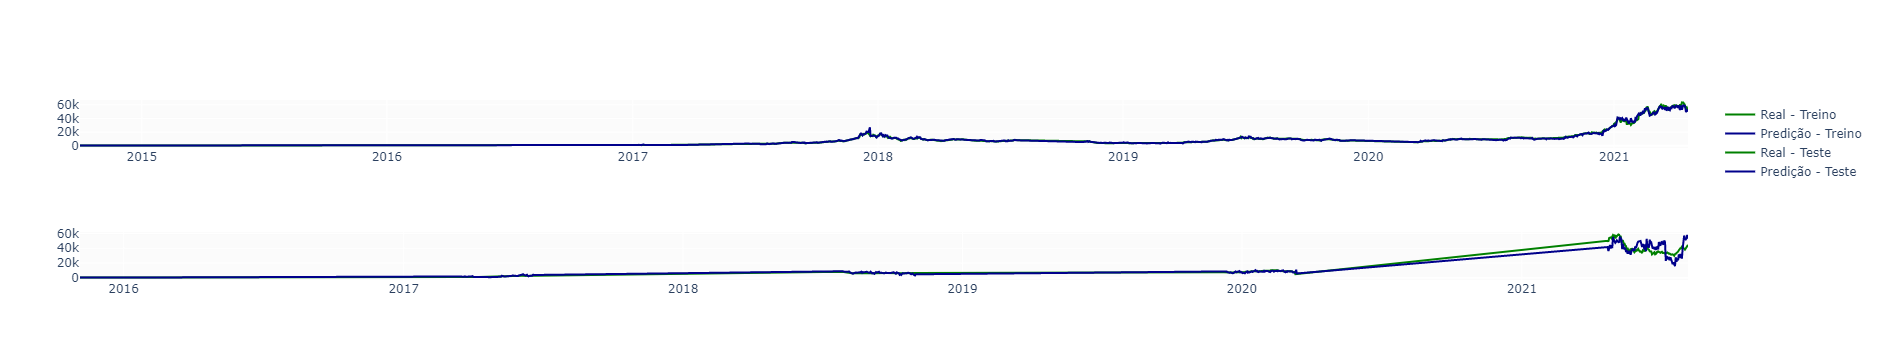



DataFrame consolidado de parâmetros e resultados tentados até aqui:


learning_rate  n_estimators  max_depth  min_child_weight  gamma  subsample  \
0           0.10         368.0        5.0               1.0    0.0        0.8   
1           0.10         368.0        7.0               7.0    0.0        0.8   
2           0.10         534.0        7.0               7.0    0.0        0.8   
3           0.01         534.0        7.0               7.0    0.0        0.8   
4           0.01        1000.0        7.0               7.0    0.0        0.8   
5           0.01         534.0        7.0               7.0    0.0        0.8   
6           0.01        1000.0        7.0               7.0    0.0        0.8   
7           0.01        1000.0        7.0               7.0    0.0        0.8   
8           0.01        1500.0        7.0               7.0    0.0        0.8   
9           0.01        1200.0        7.0               7.0    0.0        0.8   

   colsample_bytree  reg_alpha  reg_lambda  MAPE_train  MAPE_test  \
0               0.8       0.00         1.0    0.047017   0.201128   
1               0.8       0.00         1.0    0.028858   0.196982   
2               0.9       0.05         1.0    0.008663   0.195569   
3               0.9       0.05         1.0    0.097159   0.214990   
4               0.9       0.05        50.0    0.106906   0.191463   
5               0.9       0.05         1.0    0.097159   0.214990   
6               0.9       0.05       100.0    0.118169   0.199755   
7               0.9       0.05        75.0    0.112329   0.196748   
8               0.9       0.05        25.0    0.085341   0.194884   
9               0.9       0.08        40.0    0.097422   0.192636   

     MSE_train     MSE_test   MAE_train     MAE_test    RMSE_train  \
0    91.487656  4472.302968   66.536871  2231.827463  8.369991e+03   
1    52.814231  4213.993190   36.528834  2103.074258  2.789343e+03   
2    12.494121  4386.504894    8.958208  2182.083626  1.561031e+02   
3   639.265604  4714.011135  339.388774  2358.883374  4.086605e+05   
4  1169.497607  4563.714721  507.792921  2294.092362  1.367725e+06   
5   639.265604  4714.011135  339.388774  2358.883374  4.086605e+05   
6  1583.254660  4644.079930  673.732515  2404.528026  2.506695e+06   
7  1388.311746  4603.428085  591.859031  2353.906328  1.927410e+06   
8   615.832295  4314.682285  294.263210  2132.523649  3.792494e+05   
9   929.144263  4476.534468  409.540697  2226.865531  8.633091e+05   

      RMSE_test  
0  2.000149e+07  
1  1.775774e+07  
2  1.924143e+07  
3  2.222190e+07  
4  2.082749e+07  
5  2.222190e+07  
6  2.156748e+07  
7  2.119155e+07  
8  1.861648e+07  
9  2.003936e+07

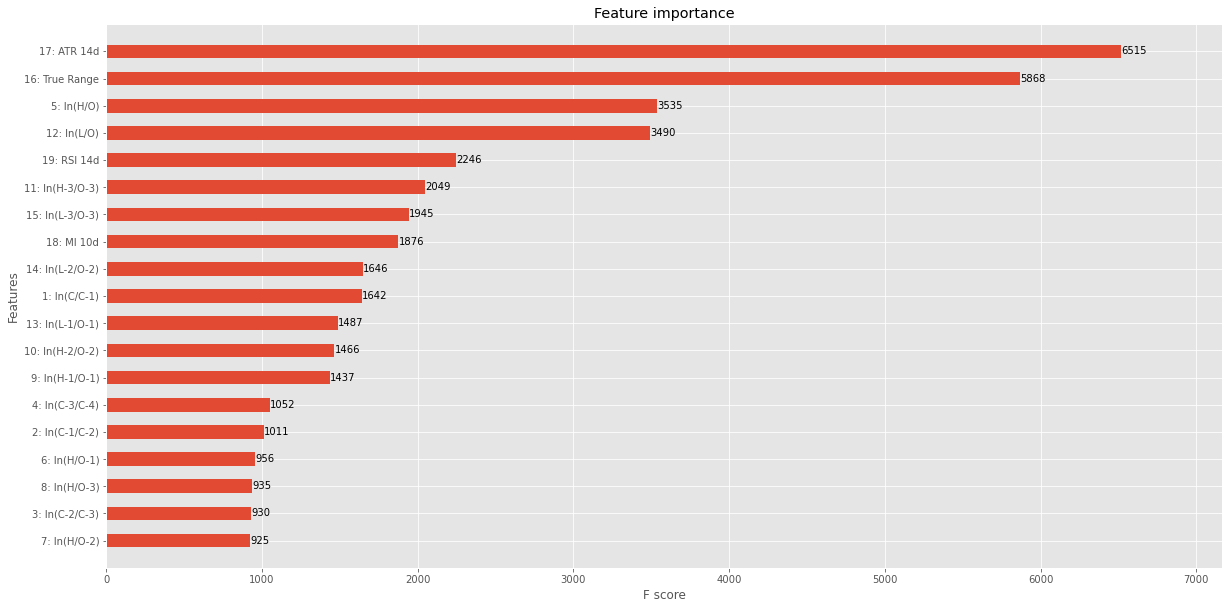

In [487]:
xgb6 = xgb.XGBRegressor(
         learning_rate =0.01,
         n_estimators=1200,
         max_depth=7,
         min_child_weight=7,
         gamma=0.0,
         colsample_bytree=0.9,
         subsample = 0.8,
         reg_alpha = 0.08,
         reg_lambda = 40,
         objective= 'reg:squarederror',
         nthread=6,
         seed=248)

model_fit(estimator = xgb6, dtrain = list(dict_train.values())[0], dtest = list(dict_test.values())[0], features = list(dict_X_train.values())[0].columns, target = 'Close', dmodel = df_model, cv_folds=10, early_stopping_rounds=50)

In [481]:
#Transcrição do colearn com Abner
#https://github.com/firefly-cpp/FireflyAlgorithm

# D é o tamanho do vagalume (# de hiperparametros)
# sol é um vagalume (uma combinação de hyperparametros)
def Fun(D, sol):

    xgb = (max_depth = sol[0], min_ = sol[1], ...) #cria o xgboost
    xfgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    erro = rmse(y_pred, y_test)        
    return erro

#fireflies = [ [ 0.1, 3, 0.01 ], [ 0.01, 2, 0.02 ]  ]

Algorithm = FireflyAlgorithm(3, 2, 10000, 0.5, 0.2, 1.0, -2.0, 2.0, Fun)
Best = Algorithm.Run()

#print Best

SyntaxError: invalid syntax (<ipython-input-481-982149993454>, line 8)